##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [1]:
!pip install -q tensorflow-gpu==2.1.0

Install TensorFlow Quantum:

In [31]:
!pip install tensorflow-quantum

  Using cached https://files.pythonhosted.org/packages/e2/60/3c73e8c4b68efdd84927e3a2975c52fbf9af50305c3dbecbf0557b8f7b73/tensorflow_quantum-0.3.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/21/21/f4105795ca7f35c541d82c5b06be684dd2f5cb4f508fb487cd7aea4de776/sympy-1.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b8/cf/d95635b4b0de2227956077687277426299883ccdb9e6418fa6e599893ea3/cirq-0.8.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/17/5d/1b9d6d3c7995fff473f35861d674e0113a5f0bd5a72fe0199c3f254665c7/freezegun-0.3.15-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0c/0e/3f026d0645d699e7320b59952146d56ad7c374e9cd72cd16e7c74e657a0f/typing_extensions-3.7.4.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d2/fb/29de8d08967f0cce1bb10b39846d836b0f3bf6776ddc36aed7c73498ca7e/protobuf-3.8.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached http

    Uninstalling networkx-2.2:
      Successfully uninstalled networkx-2.2
  Found existing installation: google-auth 1.11.0
    Uninstalling google-auth-1.11.0:
      Successfully uninstalled google-auth-1.11.0
  Found existing installation: grpcio 1.17.1
    Uninstalling grpcio-1.17.1:
      Successfully uninstalled grpcio-1.17.1


In [1]:
!pip install --upgrade protobuf

    100% |████████████████████████████████| 1.3MB 17.6MB/s ta 0:00:01
cirq 0.8.0 has requirement protobuf==3.8.0, but you'll have protobuf 3.12.2 which is incompatible.
  Found existing installation: protobuf 3.8.0
    Uninstalling protobuf-3.8.0:
      Successfully uninstalled protobuf-3.8.0


Now import TensorFlow and the module dependencies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, SPSA

In [6]:
!pip install matplotlib seaborn

     |████████████████████████████████| 215 kB 5.9 MB/s eta 0:00:01


In [20]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import tensorflow_quantum as tfq



import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [27]:
print(cirq.unitary(cirq.XX(0,1)*0.5))

AttributeError: 'int' object has no attribute 'dimension'

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Circ circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


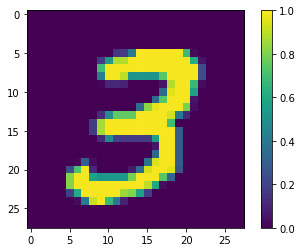

In [6]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [7]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Again, display the first training example—after resize: 

True


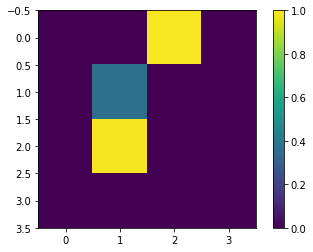

In [8]:
print(y_train[0])

plt.imshow(x_train_small[9750,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [9]:
def convert_to_angle(b_st):
    if b_st[0] == 1:
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == 1 and b_st[2] == 1:
        varphi = np.pi / 4

    if b_st[1] == 1 and b_st[2] == 0:
        varphi = 3 * np.pi / 4

    if b_st[1] == 0 and b_st[2] == 0:
        varphi = -3 * np.pi / 4

    if b_st[1] == 0 and b_st[2] == 1:
        varphi = -np.pi / 4
            
    return [theta, varphi]

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [10]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [11]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520


The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

### 1.3 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [12]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.int32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.int32)

In [13]:
# x_train_bin, y_train_nocon = remove_contradicting(x_train_bin, y_train)
_ = remove_contradicting(x_train_bin, y_train)

Number of unique images: 193
Number of 3s:  158
Number of 6s:  160
Number of contradictory images:  125

Initial number of examples:  11520
Remaining non-contradictory examples:  91


In [14]:
x_train_bin.shape, y_train_nocon.shape

((11520, 4, 4, 1), (11520,))

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

# Flatten Encoding
Encode pixel by flatten

In [130]:
# x_train_flatten = x_train_bin.reshape((-1,16))
# x_test_flatten = x_test_bin.reshape((-1,16))

In [39]:
data_train = []
data_test = []
    
# Count required bit
num_bit = 36
num_qubit = num_bit // 3

def encode31(data):
    
    var_list = []
    for i in range(2):
        for j in range(2):
            encode_dat = data[i:i+3, j:j+3].reshape([-1, 3])
            for dat in encode_dat:
                var_list += convert_to_angle(dat)

    return var_list


# num_bit = 24
# num_qubit = num_bit // 3
# def encode31(data):

#     var_list = []
#     for i in range(4):
#         for j in range(2):
#             encode_dat = data[i, j:j+3].reshape(-1)
#             var_list += convert_to_angle(encode_dat)

#     return var_list
    
# Encode train

for row in x_train_bin:
    data_train.append(encode31(row))
    
for row in x_test_bin:
    data_test.append(encode31(row))

data_train = np.array(data_train)
data_test = np.array(data_test)

In [15]:
data_train = []
data_test = []
    
# Count required bit
num_bit = 48
num_qubit = num_bit // 3

def encode31(data):
    data = np.squeeze(data)
    
    var_list = []
    for i in range(4):
        for j in range(2):
            encode_dat = data[i, j:j+3].reshape(-1)
#             convert_to_angle(encode_dat)
#             print(encode_dat.shape)
            var_list += convert_to_angle(encode_dat)
            
    dataT = data.T
    for i in range(4):
        for j in range(2):
            encode_dat = dataT[i, j:j+3].reshape(-1)
            var_list += convert_to_angle(encode_dat)

    return var_list
    
# Encode train

for row in x_train_bin:
    data_train.append(encode31(row))
    
for row in x_test_bin:
    data_test.append(encode31(row))

data_train = np.array(data_train)
data_test = np.array(data_test)

In [16]:
data_train.shape

(11520, 32)

In [53]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.circuit import QuantumCircuit, Parameter

s = [0,1,1]

theta, varphi = convert_to_angle(s)

sv = Statevector.from_label('0')
mycircuit = QuantumCircuit(1)
mycircuit.u3(theta, varphi, 0, 0)

new_sv = sv.evolve(mycircuit)
# mycircuit.draw('mpl')
plot_bloch_multivector(new_sv.data)

ModuleNotFoundError: No module named 'qiskit'

In [17]:
theta, varphi

(2.186276035465284, 0.7853981633974483)

/home/hpc/anaconda3/envs/deeplr/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  if sys.path[0] == '':


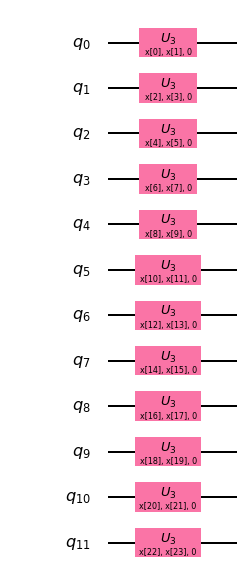

In [18]:
# Make feature map with encoder
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data_train.shape[1])]

var_form = variational_forms.RYRZ(num_qubit, depth=6)

qc = QuantumCircuit(num_qubit)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc 
feature_map.draw('mpl')

In [17]:
# Make training data

training_input = {
    0: data_train[y_train_nocon == 0][:500],
    1: data_train[y_train_nocon == 1][:500]
}
test_input = {
    0: data_test[y_test == 0],
    1: data_test[y_test == 1]
}


In [19]:
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

seed = 10598

vqc_encode_only_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_log.append(loss)

qsvm_encode = VQC(SPSA(100), feature_map, var_form, training_input, test_input, callback=loss_history_callback)

# backend = BasicAer.get_backend('qasm_simulator')

backend_options = {"method": "statevector_gpu"}
backend = QasmSimulator(backend_options)

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

C:\Users\DELL GAMING\Miniconda3\envs\deeplr\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  # This is added back by InteractiveShellApp.init_path()
2020-07-23 15:44:04,868:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.2
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initi

2020-07-23 15:45:07,378:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6985299875990829
2020-07-23 15:45:32,743:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 15:46:06,565:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6974985870026036
2020-07-23 15:46:32,256:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 15:47:07,045:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7011647292007592
2020-07-23 15:47:32,374:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 15:48:16,494:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7113018973442183
2020-07-23 15:48:41,805:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 15:49:17,050:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-07-23 16:20:43,338:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7186534849715573
2020-07-23 16:21:09,097:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 16:21:44,052:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.711987339298705
2020-07-23 16:22:10,544:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 16:22:45,908:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6991291367454521
2020-07-23 16:23:12,227:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 16:23:47,057:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7273413646722577
2020-07-23 16:24:13,079:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 16:24:48,789:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate ba

2020-07-23 16:47:30,592:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6727263297656174
2020-07-23 16:47:56,725:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 16:48:33,811:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6855175757742836
2020-07-23 16:48:33,811:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 10: 0.6727263
2020-07-23 16:48:33,811:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 10: 0.6855176
2020-07-23 16:49:01,332:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 16:49:37,560:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6883789185688176
2020-07-23 16:50:03,959:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 16:50:41,336:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-23 17:11:54,180:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 21: 0.6638741
2020-07-23 17:12:19,856:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 17:13:08,373:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6610455867055652
2020-07-23 17:13:34,295:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 17:14:11,779:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6599874592987035
2020-07-23 17:14:11,779:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 22: 0.6610456
2020-07-23 17:14:11,779:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 22: 0.6599875
2020-07-23 17:14:37,843:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 17:15:15,403:qiskit.aqua.algorithms.classifi

2020-07-23 17:37:41,627:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6604841618366488
2020-07-23 17:37:41,627:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 33: 0.6576297
2020-07-23 17:37:41,627:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 33: 0.6604842
2020-07-23 17:38:08,115:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 17:38:45,216:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.645021396956715
2020-07-23 17:39:11,142:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 17:39:48,830:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6688216164451576
2020-07-23 17:39:48,830:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 34: 0.6450214
2020-07-23 17:39:48,830:qiskit.aqua.components.optimizers

2020-07-23 18:02:11,537:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6388535297340013
2020-07-23 18:02:37,499:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 18:03:15,588:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.623740526807869
2020-07-23 18:03:15,588:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 45: 0.6388535
2020-07-23 18:03:15,603:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 45: 0.6237405
2020-07-23 18:03:42,151:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 18:04:19,301:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6158905877879479
2020-07-23 18:04:45,531:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 18:05:23,854:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-23 18:26:45,364:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 56: 0.6180169
2020-07-23 18:27:10,961:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 18:27:49,124:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6201514376581329
2020-07-23 18:28:14,447:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 18:28:52,229:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6177583257370965
2020-07-23 18:28:52,229:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 57: 0.6201514
2020-07-23 18:28:52,229:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 57: 0.6177583
2020-07-23 18:29:17,588:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 18:29:55,502:qiskit.aqua.algorithms.classifi

2020-07-23 18:52:31,305:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6114704419989269
2020-07-23 18:52:31,305:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 68: 0.6016294
2020-07-23 18:52:31,305:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 68: 0.6114704
2020-07-23 18:52:57,135:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 18:53:34,983:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6049273423562418
2020-07-23 18:54:00,635:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 18:54:38,202:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6111594258392072
2020-07-23 18:54:38,218:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 69: 0.6049273
2020-07-23 18:54:38,218:qiskit.aqua.components.optimizer

2020-07-23 19:16:54,608:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5872130251904907
2020-07-23 19:17:20,460:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 19:17:58,050:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5888110169590075
2020-07-23 19:17:58,066:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 80: 0.5872130
2020-07-23 19:17:58,066:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 80: 0.5888110
2020-07-23 19:18:24,525:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 19:19:02,384:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5979833076779824
2020-07-23 19:19:28,647:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 19:20:06,251:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-23 19:41:19,450:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 91: 0.5812967
2020-07-23 19:41:44,727:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 19:42:22,432:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5676735089742052
2020-07-23 19:42:50,565:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 19:43:27,955:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5725722508960537
2020-07-23 19:43:27,955:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 92: 0.5676735
2020-07-23 19:43:27,955:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 92: 0.5725723
2020-07-23 19:43:53,419:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 19:44:31,633:qiskit.aqua.algorithms.classifi

In [21]:
tmp = qsvm_encode.predict(data_test)

2020-07-23 20:05:19,311:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-07-23 20:06:11,564:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.


In [26]:
qsvm_encode.save_model('models/500_samples_mnist')

In [25]:
np.mean(tmp[1] == y_test)

0.6570121951219512

In [19]:
# Make training data

training_input = {
    0: data_train[y_train_nocon == 0],
    1: data_train[y_train_nocon == 1]
}
test_input = {
    0: data_test[y_test == 0],
    1: data_test[y_test == 1]
}


In [ ]:
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

seed = 10598

vqc_encode_only_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_log.append(loss)

qsvm_encode = VQC(SPSA(10000), feature_map, var_form, training_input, test_input, minibatch_size=200, callback=loss_history_callback)

# backend = BasicAer.get_backend('qasm_simulator')

backend_options = {"method": "statevector_gpu"}
backend = QasmSimulator(backend_options)

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

/home/hpc/anaconda3/envs/deeplr/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  # This is added back by InteractiveShellApp.init_path()
2020-07-24 02:51:00,159:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.2
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial

2020-07-24 02:51:00,169:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-07-24 02:51:00,172:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-24 02:51:00,174:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-24 02:51:00,175:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-24 02:51:03,058:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:51:05,040:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6779836126471431
2020-07-24 02:51:07,353:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:51:09,521:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6957409948560607
2020-07-24 02:51:11,810:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-07-24 02:53:33,288:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:53:35,294:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6868775511710576
2020-07-24 02:53:37,877:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:53:39,977:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6986209477921201
2020-07-24 02:53:42,252:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:53:44,420:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6828958392073975
2020-07-24 02:53:46,891:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:53:48,927:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6808491707716747
2020-07-24 02:53:51,320:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validat

2020-07-24 02:55:43,320:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.6861609
2020-07-24 02:55:45,877:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:55:48,025:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6912251790884701
2020-07-24 02:55:50,287:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:55:52,259:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6916068480290457
2020-07-24 02:55:52,260:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6912252
2020-07-24 02:55:52,260:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.6916068
2020-07-24 02:55:54,846:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:55:56,929:qiskit.aqua.algorithms.classifiers

2020-07-24 02:57:31,886:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6972305226669964
2020-07-24 02:57:31,887:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.6937342
2020-07-24 02:57:31,888:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6972305
2020-07-24 02:57:34,410:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:57:36,569:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6953940609351321
2020-07-24 02:57:39,120:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:57:41,193:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6971042851210132
2020-07-24 02:57:41,194:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.6953941
2020-07-24 02:57:41,195:qiskit.aqua.components.optimizer

2020-07-24 02:59:17,876:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6962173225663321
2020-07-24 02:59:20,329:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:59:22,472:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6815568820388469
2020-07-24 02:59:22,473:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.6962173
2020-07-24 02:59:22,473:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.6815569
2020-07-24 02:59:24,819:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:59:26,885:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6897452670303232
2020-07-24 02:59:29,241:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 02:59:31,268:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-24 03:01:02,561:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 40: 0.6941797
2020-07-24 03:01:04,910:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:01:06,980:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6752715250078707
2020-07-24 03:01:09,410:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:01:11,444:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6747447875504491
2020-07-24 03:01:11,445:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.6752715
2020-07-24 03:01:11,446:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.6747448
2020-07-24 03:01:14,064:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:01:16,141:qiskit.aqua.algorithms.classifi

2020-07-24 03:02:51,720:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6754129531683808
2020-07-24 03:02:51,721:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.6982502
2020-07-24 03:02:51,721:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.6754130
2020-07-24 03:02:54,347:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:02:56,505:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6881180460470678
2020-07-24 03:02:58,799:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:03:00,866:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6845780095321209
2020-07-24 03:03:00,866:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.6881180
2020-07-24 03:03:00,867:qiskit.aqua.components.optimizer

2020-07-24 03:06:35,397:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6812268054018634
2020-07-24 03:06:37,943:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:06:39,980:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6877323856253055
2020-07-24 03:06:39,981:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 77: 0.6812268
2020-07-24 03:06:39,981:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 77: 0.6877324
2020-07-24 03:06:42,640:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:06:44,733:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6907075866306576
2020-07-24 03:06:47,055:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:06:49,258:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-24 03:08:21,215:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 88: 0.6825965
2020-07-24 03:08:23,648:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:08:25,751:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6864174202674509
2020-07-24 03:08:28,363:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:08:30,413:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6873434315174441
2020-07-24 03:08:30,414:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 89: 0.6864174
2020-07-24 03:08:30,415:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 89: 0.6873434
2020-07-24 03:08:33,012:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:08:35,193:qiskit.aqua.algorithms.classifi

2020-07-24 03:10:12,473:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6750202784697747
2020-07-24 03:10:12,474:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 100: 0.6749185
2020-07-24 03:10:12,474:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 100: 0.6750203
2020-07-24 03:10:14,928:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:10:17,129:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6779718466973391
2020-07-24 03:10:19,667:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:10:21,721:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6679530261826935
2020-07-24 03:10:21,722:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 101: 0.6779718
2020-07-24 03:10:21,722:qiskit.aqua.components.optimi

2020-07-24 03:11:56,163:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6952774658391205
2020-07-24 03:11:58,692:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:12:00,817:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6876339204521558
2020-07-24 03:12:00,818:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 112: 0.6952775
2020-07-24 03:12:00,819:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 112: 0.6876339
2020-07-24 03:12:03,341:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:12:05,344:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6894520094036807
2020-07-24 03:12:07,903:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:12:09,908:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-24 03:13:40,228:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 123: 0.6893635
2020-07-24 03:13:42,622:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:13:44,661:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6974432817220771
2020-07-24 03:13:47,108:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:13:49,118:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6985535900284531
2020-07-24 03:13:49,119:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 124: 0.6974433
2020-07-24 03:13:49,119:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 124: 0.6985536
2020-07-24 03:13:51,526:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:13:53,606:qiskit.aqua.algorithms.class

2020-07-24 03:15:28,317:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6976278470076
2020-07-24 03:15:28,318:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 135: 0.6967705
2020-07-24 03:15:28,319:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 135: 0.6976278
2020-07-24 03:15:30,875:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:15:32,918:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6918675196450712
2020-07-24 03:15:35,494:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:15:37,493:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6965200840622138
2020-07-24 03:15:37,494:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 136: 0.6918675
2020-07-24 03:15:37,495:qiskit.aqua.components.optimizer

2020-07-24 03:17:13,660:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6876675085515738
2020-07-24 03:17:16,135:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:17:18,325:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6849853338319071
2020-07-24 03:17:18,325:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 147: 0.6876675
2020-07-24 03:17:18,326:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 147: 0.6849853
2020-07-24 03:17:20,646:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:17:22,681:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6900906063950975
2020-07-24 03:17:25,144:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:17:27,225:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-24 03:18:54,346:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 158: 0.6835535
2020-07-24 03:18:56,515:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:18:58,603:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6804502502292037
2020-07-24 03:19:01,034:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:19:03,020:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6907491823895967
2020-07-24 03:19:03,021:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 159: 0.6804503
2020-07-24 03:19:03,021:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 159: 0.6907492
2020-07-24 03:19:05,424:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:19:07,564:qiskit.aqua.algorithms.class

2020-07-24 03:20:42,320:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6860347096815611
2020-07-24 03:20:42,321:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 170: 0.6860733
2020-07-24 03:20:42,321:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 170: 0.6860347
2020-07-24 03:20:44,716:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:20:46,806:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6675839879052633
2020-07-24 03:20:49,199:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:20:51,248:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6849947790022487
2020-07-24 03:20:51,249:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 171: 0.6675840
2020-07-24 03:20:51,250:qiskit.aqua.components.optimi

2020-07-24 03:22:27,400:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6951293647419063
2020-07-24 03:22:29,637:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:22:31,674:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.696567068889979
2020-07-24 03:22:31,676:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 182: 0.6951294
2020-07-24 03:22:31,676:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 182: 0.6965671
2020-07-24 03:22:34,238:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:22:36,298:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6801833265246799
2020-07-24 03:22:38,828:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:22:41,014:qiskit.aqua.algorithms.classifiers.vqc:D

2020-07-24 03:24:11,875:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 193: 0.6840832
2020-07-24 03:24:14,484:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:24:16,604:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.694313859504997
2020-07-24 03:24:19,022:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:24:21,214:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6825929585341695
2020-07-24 03:24:21,215:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 194: 0.6943139
2020-07-24 03:24:21,215:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 194: 0.6825930
2020-07-24 03:24:23,812:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:24:25,864:qiskit.aqua.algorithms.classi

2020-07-24 03:26:01,489:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6905870568834045
2020-07-24 03:26:01,490:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 205: 0.6914844
2020-07-24 03:26:01,490:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 205: 0.6905871
2020-07-24 03:26:03,824:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:26:05,851:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6910704785458377
2020-07-24 03:26:08,228:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:26:10,239:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6806705970937014
2020-07-24 03:26:10,240:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 206: 0.6910705
2020-07-24 03:26:10,240:qiskit.aqua.components.optimi

2020-07-24 03:27:45,798:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6949340302724021
2020-07-24 03:27:48,414:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:27:50,417:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6817747446253649
2020-07-24 03:27:50,418:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 217: 0.6949340
2020-07-24 03:27:50,418:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 217: 0.6817747
2020-07-24 03:27:52,892:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:27:55,055:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6923532964564334
2020-07-24 03:27:57,584:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:27:59,559:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-24 03:29:29,722:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 228: 0.6780033
2020-07-24 03:29:32,062:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:29:34,235:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6822817192501607
2020-07-24 03:29:36,691:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:29:38,694:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6866131208094396
2020-07-24 03:29:38,695:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 229: 0.6822817
2020-07-24 03:29:38,695:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 229: 0.6866131
2020-07-24 03:29:41,207:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:29:43,379:qiskit.aqua.algorithms.class

2020-07-24 03:31:20,284:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.685668320488012
2020-07-24 03:31:20,285:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 240: 0.6827673
2020-07-24 03:31:20,286:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 240: 0.6856683
2020-07-24 03:31:22,779:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:31:24,938:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6866577284309099
2020-07-24 03:31:27,210:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:31:29,269:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6728463251321781
2020-07-24 03:31:29,270:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 241: 0.6866577
2020-07-24 03:31:29,270:qiskit.aqua.components.optimiz

2020-07-24 03:33:04,074:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6856283711083254
2020-07-24 03:33:06,412:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:33:08,466:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6896210418009567
2020-07-24 03:33:08,467:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 252: 0.6856284
2020-07-24 03:33:08,467:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 252: 0.6896210
2020-07-24 03:33:10,942:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:33:13,045:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6775541526586467
2020-07-24 03:33:15,473:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:33:17,543:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-24 03:34:48,495:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 263: 0.6817522
2020-07-24 03:34:51,161:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:34:53,212:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6788190989556463
2020-07-24 03:34:55,530:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:34:57,651:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6803833827231628
2020-07-24 03:34:57,652:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 264: 0.6788191
2020-07-24 03:34:57,652:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 264: 0.6803834
2020-07-24 03:35:00,167:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:35:02,160:qiskit.aqua.algorithms.class

2020-07-24 03:36:38,386:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6746741374721356
2020-07-24 03:36:38,386:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 275: 0.6869407
2020-07-24 03:36:38,387:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 275: 0.6746741
2020-07-24 03:36:40,954:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:36:43,231:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6853556770691209
2020-07-24 03:36:45,564:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:36:47,658:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7003377364504637
2020-07-24 03:36:47,659:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 276: 0.6853557
2020-07-24 03:36:47,660:qiskit.aqua.components.optimi

2020-07-24 03:38:25,463:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6845370075724649
2020-07-24 03:38:27,950:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:38:30,212:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6723258195561205
2020-07-24 03:38:30,213:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 287: 0.6845370
2020-07-24 03:38:30,214:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 287: 0.6723258
2020-07-24 03:38:32,819:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:38:34,846:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6810430545177657
2020-07-24 03:38:37,366:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:38:39,523:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-24 03:42:13,131:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:42:15,278:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6799168511048507
2020-07-24 03:42:17,781:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:42:19,801:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6757285601104036
2020-07-24 03:42:19,802:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 312: 0.6799169
2020-07-24 03:42:19,802:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 312: 0.6757286
2020-07-24 03:42:22,327:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:42:24,480:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6787034941956354
2020-07-24 03:42:26,822:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-24 03:43:58,213:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 323: 0.6847087
2020-07-24 03:43:58,214:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 323: 0.6726974
2020-07-24 03:44:00,749:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:44:02,811:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6777829552452853
2020-07-24 03:44:05,237:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:44:07,268:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6641880569720789
2020-07-24 03:44:07,269:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 324: 0.6777830
2020-07-24 03:44:07,269:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 324: 0.6641881
2020-07-24 03:44:09,696:qiskit.aqua.utils.

2020-07-24 03:45:44,616:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:45:46,736:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6647228475804343
2020-07-24 03:45:46,737:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 335: 0.6800359
2020-07-24 03:45:46,737:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 335: 0.6647228
2020-07-24 03:45:49,387:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:45:51,400:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6784437938931825
2020-07-24 03:45:53,867:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:45:56,029:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6820629126719862
2020-07-24 03:45:56,030:qiskit.aqua.components.optimizers.spsa:

2020-07-24 03:47:29,247:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:47:31,389:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6794519081592665
2020-07-24 03:47:33,664:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:47:35,672:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6688976908327702
2020-07-24 03:47:35,673:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 347: 0.6794519
2020-07-24 03:47:35,674:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 347: 0.6688977
2020-07-24 03:47:38,277:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:47:40,297:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6826586495794227
2020-07-24 03:47:42,812:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-24 03:49:15,186:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 358: 0.6624414
2020-07-24 03:49:15,186:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 358: 0.6655447
2020-07-24 03:49:17,564:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:49:19,632:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6609294246159669
2020-07-24 03:49:22,000:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:49:24,151:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6696407025246681
2020-07-24 03:49:24,152:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 359: 0.6609294
2020-07-24 03:49:24,153:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 359: 0.6696407
2020-07-24 03:49:26,589:qiskit.aqua.utils.

2020-07-24 03:51:00,613:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:51:02,638:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6721482933628055
2020-07-24 03:51:02,639:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 370: 0.6541153
2020-07-24 03:51:02,639:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 370: 0.6721483
2020-07-24 03:51:05,270:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:51:07,435:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6669884795021066
2020-07-24 03:51:09,726:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:51:11,760:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6746319107357127
2020-07-24 03:51:11,761:qiskit.aqua.components.optimizers.spsa:

2020-07-24 03:52:45,874:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:52:47,979:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6579113659158469
2020-07-24 03:52:50,690:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:52:52,931:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6846912122460516
2020-07-24 03:52:52,932:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 382: 0.6579114
2020-07-24 03:52:52,933:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 382: 0.6846912
2020-07-24 03:52:55,393:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:52:57,434:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6658175961489918
2020-07-24 03:53:00,031:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-24 03:54:33,902:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 393: 0.6557157
2020-07-24 03:54:33,903:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 393: 0.6397923
2020-07-24 03:54:36,281:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:54:38,342:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6638895332630064
2020-07-24 03:54:40,769:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:54:42,968:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6566733542664533
2020-07-24 03:54:42,969:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 394: 0.6638895
2020-07-24 03:54:42,970:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 394: 0.6566734
2020-07-24 03:54:45,564:qiskit.aqua.utils.

2020-07-24 03:56:21,464:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:56:23,603:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6456875757919861
2020-07-24 03:56:23,604:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 405: 0.6518523
2020-07-24 03:56:23,605:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 405: 0.6456876
2020-07-24 03:56:25,930:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:56:27,979:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6551419092534573
2020-07-24 03:56:30,532:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:56:32,514:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6443555951779341
2020-07-24 03:56:32,515:qiskit.aqua.components.optimizers.spsa:

2020-07-24 03:58:05,181:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:58:07,210:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6569665798343004
2020-07-24 03:58:09,644:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:58:11,799:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6532215824148504
2020-07-24 03:58:11,800:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 417: 0.6569666
2020-07-24 03:58:11,801:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 417: 0.6532216
2020-07-24 03:58:14,184:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:58:16,230:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6682694262963043
2020-07-24 03:58:18,585:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-24 03:59:50,986:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 428: 0.6563027
2020-07-24 03:59:50,987:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 428: 0.6426319
2020-07-24 03:59:53,673:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 03:59:55,731:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6626109289943359
2020-07-24 03:59:58,366:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:00:00,427:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6489241684789072
2020-07-24 04:00:00,428:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 429: 0.6626109
2020-07-24 04:00:00,428:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 429: 0.6489242
2020-07-24 04:00:03,041:qiskit.aqua.utils.

2020-07-24 04:01:37,699:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:01:39,719:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6653101991144487
2020-07-24 04:01:39,720:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 440: 0.6753802
2020-07-24 04:01:39,721:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 440: 0.6653102
2020-07-24 04:01:42,249:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:01:44,302:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6569719754607207
2020-07-24 04:01:46,631:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:01:48,663:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.645666149879056
2020-07-24 04:01:48,664:qiskit.aqua.components.optimizers.spsa:D

2020-07-24 04:03:21,747:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:03:23,746:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6419765658177116
2020-07-24 04:03:26,052:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:03:28,187:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6800023780904573
2020-07-24 04:03:28,188:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 452: 0.6419766
2020-07-24 04:03:28,189:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 452: 0.6800024
2020-07-24 04:03:30,602:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:03:32,592:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6713138216223918
2020-07-24 04:03:35,015:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-24 04:05:07,438:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 463: 0.6746462
2020-07-24 04:05:07,438:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 463: 0.6195551
2020-07-24 04:05:10,033:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:05:11,974:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6364103264722185
2020-07-24 04:05:14,316:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:05:16,424:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6674447723754365
2020-07-24 04:05:16,425:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 464: 0.6364103
2020-07-24 04:05:16,425:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 464: 0.6674448
2020-07-24 04:05:18,886:qiskit.aqua.utils.

2020-07-24 04:06:52,992:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:06:55,118:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6756946659769153
2020-07-24 04:06:55,119:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 475: 0.6616815
2020-07-24 04:06:55,119:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 475: 0.6756947
2020-07-24 04:06:57,612:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:06:59,645:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6770552777257586
2020-07-24 04:07:01,882:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:07:03,988:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6605944587750515
2020-07-24 04:07:03,989:qiskit.aqua.components.optimizers.spsa:

2020-07-24 04:08:38,064:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:08:40,097:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6632007052820315
2020-07-24 04:08:42,613:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:08:44,650:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6568003271177791
2020-07-24 04:08:44,651:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 487: 0.6632007
2020-07-24 04:08:44,652:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 487: 0.6568003
2020-07-24 04:08:47,224:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:08:49,345:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6070870901552073
2020-07-24 04:08:51,965:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-24 04:10:25,536:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 498: 0.6524831
2020-07-24 04:10:25,536:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 498: 0.6616724
2020-07-24 04:10:27,790:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:10:29,875:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6306620537115958
2020-07-24 04:10:32,247:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:10:34,293:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6525311466218348
2020-07-24 04:10:34,294:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 499: 0.6306621
2020-07-24 04:10:34,294:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 499: 0.6525311
2020-07-24 04:10:36,732:qiskit.aqua.utils.

2020-07-24 04:12:10,474:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:12:12,639:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6630763950715325
2020-07-24 04:12:12,640:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 510: 0.6470745
2020-07-24 04:12:12,641:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 510: 0.6630764
2020-07-24 04:12:15,119:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:12:17,089:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.638526841239197
2020-07-24 04:12:19,706:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:12:21,762:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.663966623707512
2020-07-24 04:12:21,764:qiskit.aqua.components.optimizers.spsa:DE

2020-07-24 04:13:55,743:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:13:57,883:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6729762548616673
2020-07-24 04:14:00,108:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:14:02,080:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6611924679522074
2020-07-24 04:14:02,081:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 522: 0.6729763
2020-07-24 04:14:02,082:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 522: 0.6611925
2020-07-24 04:14:04,776:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 04:14:06,838:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6646828362821992
2020-07-24 04:14:09,407:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-24 13:37:33,309:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.605812133701294
2020-07-24 13:37:35,693:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:37:37,732:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5942184408493564
2020-07-24 13:37:37,733:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4243: 0.6058121
2020-07-24 13:37:37,733:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4243: 0.5942184
2020-07-24 13:37:40,416:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:37:42,461:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5303814111507593
2020-07-24 13:37:45,028:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:37:46,956:qiskit.aqua.algorithms.classifiers.vqc

2020-07-24 13:39:17,154:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4254: 0.5854219
2020-07-24 13:39:19,696:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:39:21,770:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.581491529074096
2020-07-24 13:39:24,371:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:39:26,529:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.563713817793165
2020-07-24 13:39:26,530:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4255: 0.5814915
2020-07-24 13:39:26,531:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4255: 0.5637138
2020-07-24 13:39:28,786:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:39:30,807:qiskit.aqua.algorithms.clas

2020-07-24 13:41:06,517:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5852746414842595
2020-07-24 13:41:06,518:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4266: 0.5623066
2020-07-24 13:41:06,519:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4266: 0.5852746
2020-07-24 13:41:09,202:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:41:11,373:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5742140162426287
2020-07-24 13:41:13,655:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:41:15,709:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5859725622335427
2020-07-24 13:41:15,710:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4267: 0.5742140
2020-07-24 13:41:15,711:qiskit.aqua.components.opt

2020-07-24 13:44:29,053:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4288: 0.5540276
2020-07-24 13:44:29,053:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4288: 0.5826639
2020-07-24 13:44:31,424:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:44:33,479:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5881593891904455
2020-07-24 13:44:36,169:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:44:38,183:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5991370183835739
2020-07-24 13:44:38,184:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4289: 0.5881594
2020-07-24 13:44:38,185:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4289: 0.5991370
2020-07-24 13:44:40,760:qiskit.aqua.ut

2020-07-24 13:46:17,512:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:46:19,701:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5976826255694363
2020-07-24 13:46:19,702:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4300: 0.5680487
2020-07-24 13:46:19,703:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4300: 0.5976826
2020-07-24 13:46:22,321:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:46:24,414:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5730304484894291
2020-07-24 13:46:27,031:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:46:29,231:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5806049038575842
2020-07-24 13:46:29,232:qiskit.aqua.components.optimizers.sps

2020-07-24 13:48:02,311:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:48:04,517:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6238742772638457
2020-07-24 13:48:07,024:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:48:09,075:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5943248286054259
2020-07-24 13:48:09,076:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4312: 0.6238743
2020-07-24 13:48:09,077:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4312: 0.5943248
2020-07-24 13:48:11,627:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:48:13,756:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6086605882106735
2020-07-24 13:48:16,128:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 13:49:48,084:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4323: 0.5788268
2020-07-24 13:49:48,085:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4323: 0.6143123
2020-07-24 13:49:50,653:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:49:52,809:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6247775565419678
2020-07-24 13:49:55,074:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:49:57,102:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.546422469646358
2020-07-24 13:49:57,103:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4324: 0.6247776
2020-07-24 13:49:57,103:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4324: 0.5464225
2020-07-24 13:49:59,637:qiskit.aqua.uti

2020-07-24 13:51:34,721:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:51:36,702:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5789932484583662
2020-07-24 13:51:36,703:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4335: 0.6120945
2020-07-24 13:51:36,704:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4335: 0.5789932
2020-07-24 13:51:39,146:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:51:41,287:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5578708215956756
2020-07-24 13:51:43,579:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:51:45,560:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5787396631623023
2020-07-24 13:51:45,561:qiskit.aqua.components.optimizers.sps

2020-07-24 13:53:18,495:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:53:20,572:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5720851227719052
2020-07-24 13:53:22,962:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:53:25,035:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5559007430776353
2020-07-24 13:53:25,036:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4347: 0.5720851
2020-07-24 13:53:25,037:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4347: 0.5559007
2020-07-24 13:53:27,444:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:53:29,458:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5565607653316061
2020-07-24 13:53:31,841:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 13:55:03,135:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4358: 0.5544053
2020-07-24 13:55:03,135:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4358: 0.5226812
2020-07-24 13:55:05,625:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:55:07,689:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5670018044571165
2020-07-24 13:55:10,175:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:55:12,217:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.593030571579735
2020-07-24 13:55:12,218:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4359: 0.5670018
2020-07-24 13:55:12,219:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4359: 0.5930306
2020-07-24 13:55:14,630:qiskit.aqua.uti

2020-07-24 13:56:49,335:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:56:51,329:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5575854947735353
2020-07-24 13:56:51,330:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4370: 0.5653962
2020-07-24 13:56:51,331:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4370: 0.5575855
2020-07-24 13:56:53,724:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:56:55,808:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5634404235187339
2020-07-24 13:56:58,102:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:57:00,157:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5811924019995136
2020-07-24 13:57:00,158:qiskit.aqua.components.optimizers.sps

2020-07-24 13:58:33,937:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:58:35,959:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5129981123312107
2020-07-24 13:58:38,479:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:58:40,707:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5826129634233779
2020-07-24 13:58:40,708:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4382: 0.5129981
2020-07-24 13:58:40,708:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4382: 0.5826130
2020-07-24 13:58:43,478:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 13:58:45,485:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5896807695170142
2020-07-24 13:58:47,820:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 14:00:21,652:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4393: 0.5865412
2020-07-24 14:00:21,653:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4393: 0.5450446
2020-07-24 14:00:24,217:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:00:26,229:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5573170071142127
2020-07-24 14:00:28,617:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:00:30,795:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6193517476874015
2020-07-24 14:00:30,796:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4394: 0.5573170
2020-07-24 14:00:30,797:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4394: 0.6193517
2020-07-24 14:00:33,622:qiskit.aqua.ut

2020-07-24 14:02:10,194:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:02:12,269:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.582636505385091
2020-07-24 14:02:12,270:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4405: 0.5678219
2020-07-24 14:02:12,270:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4405: 0.5826365
2020-07-24 14:02:14,825:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:02:16,799:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5920646205195192
2020-07-24 14:02:19,362:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:02:21,405:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5450858506598765
2020-07-24 14:02:21,406:qiskit.aqua.components.optimizers.spsa

2020-07-24 14:03:53,939:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:03:55,946:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5623855322508172
2020-07-24 14:03:58,239:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:04:00,333:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6011952195628049
2020-07-24 14:04:00,334:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4417: 0.5623855
2020-07-24 14:04:00,335:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4417: 0.6011952
2020-07-24 14:04:02,960:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:04:05,028:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5898979509902748
2020-07-24 14:04:07,574:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 14:05:41,240:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4428: 0.5992727
2020-07-24 14:05:41,240:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4428: 0.5851400
2020-07-24 14:05:43,800:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:05:45,954:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6114874821266627
2020-07-24 14:05:48,246:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:05:50,275:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5889882329144793
2020-07-24 14:05:50,276:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4429: 0.6114875
2020-07-24 14:05:50,277:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4429: 0.5889882
2020-07-24 14:05:52,776:qiskit.aqua.ut

2020-07-24 14:07:27,717:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:07:29,747:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5400824140123889
2020-07-24 14:07:29,748:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4440: 0.6000313
2020-07-24 14:07:29,749:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4440: 0.5400824
2020-07-24 14:07:32,140:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:07:34,160:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.600488256121882
2020-07-24 14:07:36,749:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:07:38,732:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6115503369144284
2020-07-24 14:07:38,733:qiskit.aqua.components.optimizers.spsa

2020-07-24 14:09:10,966:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:09:13,024:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5814157234873372
2020-07-24 14:09:15,468:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:09:17,580:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6097786462745692
2020-07-24 14:09:17,581:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4452: 0.5814157
2020-07-24 14:09:17,581:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4452: 0.6097786
2020-07-24 14:09:20,311:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:09:22,371:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6000932406656967
2020-07-24 14:09:24,932:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 14:10:58,796:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4463: 0.5488671
2020-07-24 14:10:58,797:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4463: 0.6224925
2020-07-24 14:11:01,169:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:11:03,194:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5359232851518033
2020-07-24 14:11:05,749:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:11:07,732:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.546239183725643
2020-07-24 14:11:07,733:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4464: 0.5359233
2020-07-24 14:11:07,733:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4464: 0.5462392
2020-07-24 14:11:10,254:qiskit.aqua.uti

2020-07-24 14:12:45,426:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:12:47,621:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5760773006662241
2020-07-24 14:12:47,622:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4475: 0.5836426
2020-07-24 14:12:47,623:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4475: 0.5760773
2020-07-24 14:12:50,287:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:12:52,392:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5636603724928737
2020-07-24 14:12:54,883:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:12:57,071:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6147089064316938
2020-07-24 14:12:57,072:qiskit.aqua.components.optimizers.sps

2020-07-24 14:14:31,608:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:14:33,629:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6001726025499355
2020-07-24 14:14:36,036:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:14:38,102:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6523189797226396
2020-07-24 14:14:38,103:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4487: 0.6001726
2020-07-24 14:14:38,104:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4487: 0.6523190
2020-07-24 14:14:40,318:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:14:42,495:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.576923075992787
2020-07-24 14:14:44,945:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 14:16:19,481:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4498: 0.6133250
2020-07-24 14:16:19,481:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4498: 0.5688090
2020-07-24 14:16:21,873:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:16:23,955:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5907015133927936
2020-07-24 14:16:26,373:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:16:28,427:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5867408803844889
2020-07-24 14:16:28,428:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4499: 0.5907015
2020-07-24 14:16:28,428:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4499: 0.5867409
2020-07-24 14:16:30,835:qiskit.aqua.ut

2020-07-24 14:18:05,877:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:18:08,045:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5980570301353608
2020-07-24 14:18:08,046:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4510: 0.6055979
2020-07-24 14:18:08,047:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4510: 0.5980570
2020-07-24 14:18:10,300:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:18:12,365:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6072286439342391
2020-07-24 14:18:14,784:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:18:16,817:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6144834022376698
2020-07-24 14:18:16,818:qiskit.aqua.components.optimizers.sps

2020-07-24 14:19:49,040:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:19:51,103:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6359251221718863
2020-07-24 14:19:53,337:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:19:55,508:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5923118333563805
2020-07-24 14:19:55,509:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4522: 0.6359251
2020-07-24 14:19:55,509:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4522: 0.5923118
2020-07-24 14:19:58,025:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:20:00,077:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5783725641682935
2020-07-24 14:20:02,721:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 14:21:35,978:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4533: 0.5805475
2020-07-24 14:21:35,979:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4533: 0.5843160
2020-07-24 14:21:38,533:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:21:40,600:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.618573174517195
2020-07-24 14:21:43,177:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:21:45,320:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.621613414474413
2020-07-24 14:21:45,320:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4534: 0.6185732
2020-07-24 14:21:45,321:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4534: 0.6216134
2020-07-24 14:21:47,574:qiskit.aqua.util

2020-07-24 14:23:22,338:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:23:24,427:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6104081826158272
2020-07-24 14:23:24,428:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4545: 0.6184978
2020-07-24 14:23:24,429:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4545: 0.6104082
2020-07-24 14:23:27,028:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:23:29,014:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6598840908835332
2020-07-24 14:23:31,571:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:23:33,731:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6308879339121107
2020-07-24 14:23:33,732:qiskit.aqua.components.optimizers.sps

2020-07-24 14:25:06,919:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:25:09,069:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6212186532945292
2020-07-24 14:25:11,541:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:25:13,631:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5778453869987321
2020-07-24 14:25:13,632:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4557: 0.6212187
2020-07-24 14:25:13,633:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4557: 0.5778454
2020-07-24 14:25:16,301:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:25:18,461:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5888703838806486
2020-07-24 14:25:20,694:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 14:26:52,942:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4568: 0.6113244
2020-07-24 14:26:52,943:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4568: 0.6106444
2020-07-24 14:26:55,184:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:26:57,279:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6037216790389058
2020-07-24 14:26:59,787:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:27:01,859:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5978288123643674
2020-07-24 14:27:01,860:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4569: 0.6037217
2020-07-24 14:27:01,861:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4569: 0.5978288
2020-07-24 14:27:04,447:qiskit.aqua.ut

2020-07-24 14:28:40,283:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:28:42,331:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6119455808708726
2020-07-24 14:28:42,332:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4580: 0.5720807
2020-07-24 14:28:42,333:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4580: 0.6119456
2020-07-24 14:28:44,987:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:28:46,992:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5807034776286295
2020-07-24 14:28:49,589:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:28:51,712:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5598636772333951
2020-07-24 14:28:51,713:qiskit.aqua.components.optimizers.sps

2020-07-24 14:30:25,965:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:30:27,973:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6069297929734866
2020-07-24 14:30:30,384:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:30:32,549:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5807834965349074
2020-07-24 14:30:32,550:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4592: 0.6069298
2020-07-24 14:30:32,550:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4592: 0.5807835
2020-07-24 14:30:35,121:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:30:37,125:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5854253167377127
2020-07-24 14:30:39,718:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 14:32:12,786:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4603: 0.5269934
2020-07-24 14:32:12,786:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4603: 0.5265944
2020-07-24 14:32:15,445:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:32:17,484:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5428425431792161
2020-07-24 14:32:19,905:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:32:21,937:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5506940417735754
2020-07-24 14:32:21,938:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4604: 0.5428425
2020-07-24 14:32:21,938:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4604: 0.5506940
2020-07-24 14:32:24,395:qiskit.aqua.ut

2020-07-24 14:33:59,623:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:34:01,609:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5506224997925323
2020-07-24 14:34:01,610:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4615: 0.5650041
2020-07-24 14:34:01,610:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4615: 0.5506225
2020-07-24 14:34:04,185:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:34:06,329:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6044965516808921
2020-07-24 14:34:08,611:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:34:10,608:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5324467376408271
2020-07-24 14:34:10,609:qiskit.aqua.components.optimizers.sps

2020-07-24 14:35:42,910:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:35:44,908:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5992496038668392
2020-07-24 14:35:47,327:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:35:49,406:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5868774414082759
2020-07-24 14:35:49,407:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4627: 0.5992496
2020-07-24 14:35:49,407:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4627: 0.5868774
2020-07-24 14:35:51,760:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:35:53,836:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6294826874020507
2020-07-24 14:35:56,207:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 14:37:28,280:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4638: 0.5837697
2020-07-24 14:37:28,281:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4638: 0.5773801
2020-07-24 14:37:30,863:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:37:32,823:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5935153048543266
2020-07-24 14:37:35,341:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:37:37,281:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6156836655769294
2020-07-24 14:37:37,282:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4639: 0.5935153
2020-07-24 14:37:37,283:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4639: 0.6156837
2020-07-24 14:37:39,715:qiskit.aqua.ut

2020-07-24 14:39:15,001:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:39:17,016:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6064199568027757
2020-07-24 14:39:17,017:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4650: 0.5919590
2020-07-24 14:39:17,018:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4650: 0.6064200
2020-07-24 14:39:19,625:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:39:21,631:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6031756791659517
2020-07-24 14:39:24,114:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:39:26,228:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6026600146954187
2020-07-24 14:39:26,229:qiskit.aqua.components.optimizers.sps

2020-07-24 14:40:57,650:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:40:59,585:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6078251817249051
2020-07-24 14:41:02,071:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:41:04,247:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5641891204622878
2020-07-24 14:41:04,248:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4662: 0.6078252
2020-07-24 14:41:04,249:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4662: 0.5641891
2020-07-24 14:41:06,819:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:41:08,850:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5788452625534626
2020-07-24 14:41:11,369:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 14:42:43,742:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4673: 0.6335763
2020-07-24 14:42:43,743:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4673: 0.5998367
2020-07-24 14:42:46,073:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:42:48,064:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.571814762484876
2020-07-24 14:42:50,487:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:42:52,472:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.603142058821686
2020-07-24 14:42:52,473:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4674: 0.5718148
2020-07-24 14:42:52,474:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4674: 0.6031421
2020-07-24 14:42:54,857:qiskit.aqua.util

2020-07-24 14:44:30,906:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:44:32,974:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5040660966439762
2020-07-24 14:44:32,975:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4685: 0.5884964
2020-07-24 14:44:32,975:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4685: 0.5040661
2020-07-24 14:44:35,301:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:44:37,369:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5742129791326969
2020-07-24 14:44:39,802:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:44:41,970:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.524898687562663
2020-07-24 14:44:41,971:qiskit.aqua.components.optimizers.spsa

2020-07-24 14:46:16,116:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:46:18,278:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5799078849414836
2020-07-24 14:46:20,631:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:46:22,643:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5828998146066955
2020-07-24 14:46:22,644:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4697: 0.5799079
2020-07-24 14:46:22,645:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4697: 0.5828998
2020-07-24 14:46:25,235:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:46:27,252:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5656806985204167
2020-07-24 14:46:29,891:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 14:48:02,903:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4708: 0.5566677
2020-07-24 14:48:02,904:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4708: 0.5771917
2020-07-24 14:48:05,430:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:48:07,555:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6055267916859104
2020-07-24 14:48:09,866:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:48:11,923:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5363338526081847
2020-07-24 14:48:11,924:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4709: 0.6055268
2020-07-24 14:48:11,924:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4709: 0.5363339
2020-07-24 14:48:14,240:qiskit.aqua.ut

2020-07-24 14:49:50,079:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:49:52,124:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.641544741353823
2020-07-24 14:49:52,126:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4720: 0.5787706
2020-07-24 14:49:52,126:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4720: 0.6415447
2020-07-24 14:49:54,721:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:49:56,868:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5798383591997015
2020-07-24 14:49:59,382:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:50:01,436:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5676491561193862
2020-07-24 14:50:01,437:qiskit.aqua.components.optimizers.spsa

2020-07-24 14:51:34,415:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:51:36,453:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5524087523558232
2020-07-24 14:51:39,042:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:51:41,002:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.551990668312567
2020-07-24 14:51:41,003:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4732: 0.5524088
2020-07-24 14:51:41,004:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4732: 0.5519907
2020-07-24 14:51:43,584:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:51:45,725:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5565504028301794
2020-07-24 14:51:48,044:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 14:53:20,084:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4743: 0.5922371
2020-07-24 14:53:20,084:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4743: 0.5739384
2020-07-24 14:53:22,565:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:53:24,754:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5262662175500681
2020-07-24 14:53:27,029:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:53:29,019:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5808551088826841
2020-07-24 14:53:29,020:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4744: 0.5262662
2020-07-24 14:53:29,021:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4744: 0.5808551
2020-07-24 14:53:31,458:qiskit.aqua.ut

2020-07-24 14:55:06,060:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:55:08,154:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5751128539457925
2020-07-24 14:55:08,155:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4755: 0.5643604
2020-07-24 14:55:08,156:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4755: 0.5751129
2020-07-24 14:55:10,425:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:55:12,388:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5599796897480193
2020-07-24 14:55:14,837:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:55:16,852:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5552506100787112
2020-07-24 14:55:16,853:qiskit.aqua.components.optimizers.sps

2020-07-24 14:56:47,940:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:56:49,949:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5308557876431684
2020-07-24 14:56:52,651:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:56:54,647:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5564654123807182
2020-07-24 14:56:54,648:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4767: 0.5308558
2020-07-24 14:56:54,648:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4767: 0.5564654
2020-07-24 14:56:57,335:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:56:59,297:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5417010284881602
2020-07-24 14:57:01,628:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 14:58:33,400:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4778: 0.5101961
2020-07-24 14:58:33,401:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4778: 0.5210737
2020-07-24 14:58:35,761:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:58:37,895:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4783498980400567
2020-07-24 14:58:40,359:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 14:58:42,519:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5411321115769061
2020-07-24 14:58:42,520:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4779: 0.4783499
2020-07-24 14:58:42,521:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4779: 0.5411321
2020-07-24 14:58:44,792:qiskit.aqua.ut

2020-07-24 15:00:19,764:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:00:21,854:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5662408605368301
2020-07-24 15:00:21,855:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4790: 0.5649288
2020-07-24 15:00:21,856:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4790: 0.5662409
2020-07-24 15:00:24,453:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:00:26,496:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5688675965226238
2020-07-24 15:00:28,931:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:00:31,076:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5358286706583292
2020-07-24 15:00:31,077:qiskit.aqua.components.optimizers.sps

2020-07-24 15:02:05,117:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:02:07,183:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5597949348180925
2020-07-24 15:02:09,714:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:02:11,900:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6044907464722861
2020-07-24 15:02:11,901:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4802: 0.5597949
2020-07-24 15:02:11,902:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4802: 0.6044907
2020-07-24 15:02:14,432:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:02:16,508:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5257121807866618
2020-07-24 15:02:19,071:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 15:03:51,887:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4813: 0.5757542
2020-07-24 15:03:51,888:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4813: 0.5976929
2020-07-24 15:03:54,465:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:03:56,626:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5445156020632708
2020-07-24 15:03:58,868:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:04:00,865:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5624620466301973
2020-07-24 15:04:00,866:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4814: 0.5445156
2020-07-24 15:04:00,866:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4814: 0.5624620
2020-07-24 15:04:03,293:qiskit.aqua.ut

2020-07-24 15:05:38,130:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:05:40,287:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6145527283188899
2020-07-24 15:05:40,288:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4825: 0.6154950
2020-07-24 15:05:40,289:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4825: 0.6145527
2020-07-24 15:05:42,588:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:05:44,630:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.638600585688794
2020-07-24 15:05:47,207:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:05:49,154:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5932545284727786
2020-07-24 15:05:49,155:qiskit.aqua.components.optimizers.spsa

2020-07-24 15:07:23,266:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:07:25,247:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.583864662385746
2020-07-24 15:07:27,809:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:07:30,023:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6265941425034599
2020-07-24 15:07:30,024:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4837: 0.5838647
2020-07-24 15:07:30,025:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4837: 0.6265941
2020-07-24 15:07:32,370:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:07:34,372:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5623157342713359
2020-07-24 15:07:37,066:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 15:09:09,858:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4848: 0.5891365
2020-07-24 15:09:09,859:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4848: 0.5873296
2020-07-24 15:09:12,405:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:09:14,411:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5824218855637207
2020-07-24 15:09:16,969:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:09:19,125:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5458049694419309
2020-07-24 15:09:19,126:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4849: 0.5824219
2020-07-24 15:09:19,126:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4849: 0.5458050
2020-07-24 15:09:21,627:qiskit.aqua.ut

2020-07-24 15:10:56,989:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:10:59,047:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5503515334273195
2020-07-24 15:10:59,048:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4860: 0.5542776
2020-07-24 15:10:59,049:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4860: 0.5503515
2020-07-24 15:11:01,434:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:11:03,463:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5677761734256294
2020-07-24 15:11:05,870:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:11:07,883:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6152806465691639
2020-07-24 15:11:07,884:qiskit.aqua.components.optimizers.sps

2020-07-24 15:12:39,809:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:12:41,820:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5466337207109577
2020-07-24 15:12:44,230:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:12:46,287:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5817136533451045
2020-07-24 15:12:46,288:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4872: 0.5466337
2020-07-24 15:12:46,289:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4872: 0.5817137
2020-07-24 15:12:48,861:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:12:50,905:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.625796827000621
2020-07-24 15:12:53,400:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 15:14:27,495:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4883: 0.6103117
2020-07-24 15:14:27,496:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4883: 0.5822657
2020-07-24 15:14:30,124:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:14:32,285:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5774727055795438
2020-07-24 15:14:34,646:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:14:36,688:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5757781581299812
2020-07-24 15:14:36,689:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4884: 0.5774727
2020-07-24 15:14:36,689:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4884: 0.5757782
2020-07-24 15:14:39,310:qiskit.aqua.ut

2020-07-24 15:16:15,323:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:16:17,476:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.573668707572129
2020-07-24 15:16:17,477:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4895: 0.5718345
2020-07-24 15:16:17,478:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4895: 0.5736687
2020-07-24 15:16:19,920:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:16:22,089:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5934855340433802
2020-07-24 15:16:24,386:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:16:26,417:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5662942132433126
2020-07-24 15:16:26,419:qiskit.aqua.components.optimizers.spsa

2020-07-24 15:18:00,576:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:18:02,741:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5966962823994243
2020-07-24 15:18:05,125:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:18:07,180:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5832239625589678
2020-07-24 15:18:07,181:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4907: 0.5966963
2020-07-24 15:18:07,182:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4907: 0.5832240
2020-07-24 15:18:09,606:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:18:11,606:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5477254540721469
2020-07-24 15:18:14,086:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 15:19:46,520:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4918: 0.6037252
2020-07-24 15:19:46,521:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4918: 0.5283498
2020-07-24 15:19:49,029:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:19:51,165:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.555333119056392
2020-07-24 15:19:53,587:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:19:55,630:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5984510558174806
2020-07-24 15:19:55,632:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4919: 0.5553331
2020-07-24 15:19:55,632:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4919: 0.5984511
2020-07-24 15:19:58,423:qiskit.aqua.uti

2020-07-24 15:21:32,846:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:21:34,972:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5554097885365755
2020-07-24 15:21:34,973:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4930: 0.5772843
2020-07-24 15:21:34,973:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4930: 0.5554098
2020-07-24 15:21:37,382:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:21:39,422:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6203631237814569
2020-07-24 15:21:42,075:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:21:44,066:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6013373532756677
2020-07-24 15:21:44,067:qiskit.aqua.components.optimizers.sps

2020-07-24 15:23:17,087:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:23:19,244:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.571769170214211
2020-07-24 15:23:21,499:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:23:23,505:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5778933865893379
2020-07-24 15:23:23,506:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4942: 0.5717692
2020-07-24 15:23:23,506:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4942: 0.5778934
2020-07-24 15:23:25,867:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:23:27,922:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6163352132701126
2020-07-24 15:23:30,220:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 15:25:03,384:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4953: 0.5180535
2020-07-24 15:25:03,384:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4953: 0.5029141
2020-07-24 15:25:05,775:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:25:07,784:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5522628929623894
2020-07-24 15:25:10,142:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:25:12,169:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5948111036587761
2020-07-24 15:25:12,170:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4954: 0.5522629
2020-07-24 15:25:12,171:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4954: 0.5948111
2020-07-24 15:25:14,657:qiskit.aqua.ut

2020-07-24 15:26:49,409:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:26:51,531:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5119122110840446
2020-07-24 15:26:51,532:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4965: 0.5183585
2020-07-24 15:26:51,532:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4965: 0.5119122
2020-07-24 15:26:54,016:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:26:55,988:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5085865686236177
2020-07-24 15:26:58,472:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:27:00,611:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6276998886879682
2020-07-24 15:27:00,612:qiskit.aqua.components.optimizers.sps

2020-07-24 15:28:34,459:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:28:36,558:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5455012142142224
2020-07-24 15:28:39,128:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:28:41,162:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5848892639889242
2020-07-24 15:28:41,163:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4977: 0.5455012
2020-07-24 15:28:41,164:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4977: 0.5848893
2020-07-24 15:28:43,830:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:28:45,940:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5279342290790322
2020-07-24 15:28:48,144:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 15:30:21,952:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4988: 0.5388970
2020-07-24 15:30:21,953:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4988: 0.6292541
2020-07-24 15:30:24,403:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:30:26,525:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5784477212426646
2020-07-24 15:30:29,116:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:30:31,232:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.602757092133257
2020-07-24 15:30:31,233:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 4989: 0.5784477
2020-07-24 15:30:31,234:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 4989: 0.6027571
2020-07-24 15:30:33,608:qiskit.aqua.uti

2020-07-24 15:32:10,876:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:32:12,952:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6285877370379985
2020-07-24 15:32:12,953:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5000: 0.5070711
2020-07-24 15:32:12,953:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5000: 0.6285877
2020-07-24 15:32:15,438:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:32:17,498:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5408622451842932
2020-07-24 15:32:20,159:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:32:22,204:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5399802321245417
2020-07-24 15:32:22,205:qiskit.aqua.components.optimizers.sps

2020-07-24 15:33:55,134:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:33:57,172:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6084745702718565
2020-07-24 15:33:59,571:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:34:01,658:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6119425331037504
2020-07-24 15:34:01,659:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5012: 0.6084746
2020-07-24 15:34:01,660:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5012: 0.6119425
2020-07-24 15:34:04,034:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:34:06,119:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6050860866514125
2020-07-24 15:34:08,528:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 15:35:41,337:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5023: 0.5640042
2020-07-24 15:35:41,338:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5023: 0.6087625
2020-07-24 15:35:43,909:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:35:45,935:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6032764069508039
2020-07-24 15:35:48,483:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:35:50,649:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5458312803726162
2020-07-24 15:35:50,650:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5024: 0.6032764
2020-07-24 15:35:50,651:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5024: 0.5458313
2020-07-24 15:35:52,987:qiskit.aqua.ut

2020-07-24 15:37:27,986:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:37:29,996:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6113663608154891
2020-07-24 15:37:29,997:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5035: 0.6395999
2020-07-24 15:37:29,998:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5035: 0.6113664
2020-07-24 15:37:32,415:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:37:34,497:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6151600412532741
2020-07-24 15:37:36,615:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:37:38,726:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6175678898966068
2020-07-24 15:37:38,727:qiskit.aqua.components.optimizers.sps

2020-07-24 15:39:11,451:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:39:13,589:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6018710268132209
2020-07-24 15:39:16,105:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:39:18,184:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6029450087819582
2020-07-24 15:39:18,185:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5047: 0.6018710
2020-07-24 15:39:18,186:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5047: 0.6029450
2020-07-24 15:39:20,806:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:39:22,792:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5941246919793562
2020-07-24 15:39:25,396:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 15:40:59,074:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5058: 0.5813468
2020-07-24 15:40:59,074:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5058: 0.5600237
2020-07-24 15:41:01,480:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:41:03,639:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6113183980659249
2020-07-24 15:41:05,888:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:41:07,909:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5984888203242589
2020-07-24 15:41:07,910:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5059: 0.6113184
2020-07-24 15:41:07,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5059: 0.5984888
2020-07-24 15:41:10,607:qiskit.aqua.ut

2020-07-24 15:42:45,719:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:42:47,747:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.555316276469485
2020-07-24 15:42:47,748:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5070: 0.5818602
2020-07-24 15:42:47,748:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5070: 0.5553163
2020-07-24 15:42:50,091:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:42:52,161:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5713519491239807
2020-07-24 15:42:54,463:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:42:56,432:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5894151804721361
2020-07-24 15:42:56,433:qiskit.aqua.components.optimizers.spsa

2020-07-24 15:44:31,315:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:44:33,315:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49218408800835417
2020-07-24 15:44:35,738:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:44:37,921:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5661651055595257
2020-07-24 15:44:37,922:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5082: 0.4921841
2020-07-24 15:44:37,923:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5082: 0.5661651
2020-07-24 15:44:40,364:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:44:42,475:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.59420865175142
2020-07-24 15:44:44,784:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 15:46:17,817:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5093: 0.5880918
2020-07-24 15:46:17,817:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5093: 0.5651291
2020-07-24 15:46:20,351:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:46:22,442:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5704293755835876
2020-07-24 15:46:25,150:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:46:27,248:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6300212412136852
2020-07-24 15:46:27,249:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5094: 0.5704294
2020-07-24 15:46:27,249:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5094: 0.6300212
2020-07-24 15:46:29,923:qiskit.aqua.ut

2020-07-24 15:48:06,016:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:48:08,161:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5597010511203246
2020-07-24 15:48:08,162:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5105: 0.5619234
2020-07-24 15:48:08,162:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5105: 0.5597011
2020-07-24 15:48:10,648:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:48:12,619:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5755121338704
2020-07-24 15:48:15,148:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:48:17,134:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.530508316019612
2020-07-24 15:48:17,135:qiskit.aqua.components.optimizers.spsa:DE

2020-07-24 15:49:50,346:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:49:52,412:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5790939878026315
2020-07-24 15:49:54,968:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:49:57,098:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.591128431380099
2020-07-24 15:49:57,099:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5117: 0.5790940
2020-07-24 15:49:57,100:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5117: 0.5911284
2020-07-24 15:49:59,418:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:50:01,487:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6047530865927289
2020-07-24 15:50:04,217:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 15:51:38,066:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5128: 0.5907125
2020-07-24 15:51:38,066:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5128: 0.5932040
2020-07-24 15:51:40,320:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:51:42,385:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.615702384532641
2020-07-24 15:51:44,820:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:51:46,823:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5766202587392816
2020-07-24 15:51:46,824:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5129: 0.6157024
2020-07-24 15:51:46,825:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5129: 0.5766203
2020-07-24 15:51:49,376:qiskit.aqua.uti

2020-07-24 15:53:24,466:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:53:26,442:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5046122347958576
2020-07-24 15:53:26,443:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5140: 0.6016309
2020-07-24 15:53:26,444:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5140: 0.5046122
2020-07-24 15:53:28,945:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:53:31,096:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5723542798732245
2020-07-24 15:53:33,544:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:53:35,530:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5952336676453661
2020-07-24 15:53:35,531:qiskit.aqua.components.optimizers.sps

2020-07-24 15:55:08,749:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:55:10,928:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5566201561136542
2020-07-24 15:55:13,239:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:55:15,304:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5777969057589645
2020-07-24 15:55:15,305:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5152: 0.5566202
2020-07-24 15:55:15,305:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5152: 0.5777969
2020-07-24 15:55:17,750:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:55:19,807:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5673223713539101
2020-07-24 15:55:22,245:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 15:56:54,536:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5163: 0.5484379
2020-07-24 15:56:54,537:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5163: 0.6125314
2020-07-24 15:56:57,193:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:56:59,164:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5395713678840106
2020-07-24 15:57:01,721:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:57:03,862:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5454196533275837
2020-07-24 15:57:03,863:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5164: 0.5395714
2020-07-24 15:57:03,864:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5164: 0.5454197
2020-07-24 15:57:06,314:qiskit.aqua.ut

2020-07-24 15:58:42,474:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:58:44,664:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5797326375062927
2020-07-24 15:58:44,665:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5175: 0.5557866
2020-07-24 15:58:44,665:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5175: 0.5797326
2020-07-24 15:58:46,972:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:58:48,974:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5151013698866773
2020-07-24 15:58:51,409:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 15:58:53,515:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5954637872777275
2020-07-24 15:58:53,516:qiskit.aqua.components.optimizers.sps

2020-07-24 16:00:27,605:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:00:29,700:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.553986022844856
2020-07-24 16:00:32,135:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:00:34,371:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5992092054918243
2020-07-24 16:00:34,372:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5187: 0.5539860
2020-07-24 16:00:34,372:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5187: 0.5992092
2020-07-24 16:00:36,855:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:00:39,072:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5094519301688655
2020-07-24 16:00:41,312:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 16:02:15,250:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5198: 0.5716736
2020-07-24 16:02:15,250:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5198: 0.5224458
2020-07-24 16:02:17,872:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:02:19,986:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5553165893964253
2020-07-24 16:02:22,394:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:02:24,490:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5185745125325187
2020-07-24 16:02:24,491:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5199: 0.5553166
2020-07-24 16:02:24,492:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5199: 0.5185745
2020-07-24 16:02:26,881:qiskit.aqua.ut

2020-07-24 16:04:01,908:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:04:04,082:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5373017192842284
2020-07-24 16:04:04,083:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5210: 0.5054364
2020-07-24 16:04:04,083:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5210: 0.5373017
2020-07-24 16:04:06,344:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:04:08,371:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5543393881496353
2020-07-24 16:04:10,654:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:04:12,675:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5402658939523172
2020-07-24 16:04:12,676:qiskit.aqua.components.optimizers.sps

2020-07-24 16:05:46,194:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:05:48,305:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5588710626385
2020-07-24 16:05:50,564:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:05:52,712:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5250466758053403
2020-07-24 16:05:52,713:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5222: 0.5588711
2020-07-24 16:05:52,714:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5222: 0.5250467
2020-07-24 16:05:55,303:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:05:57,372:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5493995556452752
2020-07-24 16:05:59,906:qiskit.aqua.utils.run_circuits:INFO: Can

2020-07-24 16:07:32,074:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5233: 0.5183957
2020-07-24 16:07:32,074:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5233: 0.5122116
2020-07-24 16:07:34,370:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:07:36,368:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5919331660820208
2020-07-24 16:07:38,758:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:07:40,804:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5502149712684287
2020-07-24 16:07:40,805:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5234: 0.5919332
2020-07-24 16:07:40,805:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5234: 0.5502150
2020-07-24 16:07:43,225:qiskit.aqua.ut

2020-07-24 16:09:17,970:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:09:20,119:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.553595124505656
2020-07-24 16:09:20,120:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5245: 0.5493131
2020-07-24 16:09:20,121:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5245: 0.5535951
2020-07-24 16:09:22,321:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:09:24,360:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6133630110404463
2020-07-24 16:09:26,682:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:09:28,728:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5607786295145686
2020-07-24 16:09:28,729:qiskit.aqua.components.optimizers.spsa

2020-07-24 16:11:01,878:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:11:03,922:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5788946519961083
2020-07-24 16:11:06,490:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:11:08,455:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5317636929487678
2020-07-24 16:11:08,456:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5257: 0.5788947
2020-07-24 16:11:08,457:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5257: 0.5317637
2020-07-24 16:11:10,992:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:11:13,150:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.551021186320167
2020-07-24 16:11:15,516:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 16:12:48,722:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5268: 0.5617023
2020-07-24 16:12:48,722:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5268: 0.5936985
2020-07-24 16:12:51,011:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:12:53,021:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5583501033669405
2020-07-24 16:12:55,324:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:12:57,366:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.538841367015224
2020-07-24 16:12:57,367:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5269: 0.5583501
2020-07-24 16:12:57,368:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5269: 0.5388414
2020-07-24 16:13:00,007:qiskit.aqua.uti

2020-07-24 16:14:35,427:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:14:37,499:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5897521136156275
2020-07-24 16:14:37,500:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5280: 0.5309918
2020-07-24 16:14:37,501:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5280: 0.5897521
2020-07-24 16:14:40,137:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:14:42,154:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5627142156721732
2020-07-24 16:14:44,446:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:14:46,641:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5048103016940082
2020-07-24 16:14:46,642:qiskit.aqua.components.optimizers.sps

2020-07-24 16:16:20,335:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:16:22,331:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5634693324998628
2020-07-24 16:16:24,967:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:16:27,193:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5723458648920225
2020-07-24 16:16:27,194:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5292: 0.5634693
2020-07-24 16:16:27,194:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5292: 0.5723459
2020-07-24 16:16:29,760:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:16:31,946:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5532639457976578
2020-07-24 16:16:34,183:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 16:18:06,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5303: 0.5413539
2020-07-24 16:18:06,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5303: 0.5426559
2020-07-24 16:18:09,326:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:18:11,355:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5367432855259815
2020-07-24 16:18:13,887:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:18:16,018:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5637823814822595
2020-07-24 16:18:16,019:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5304: 0.5367433
2020-07-24 16:18:16,019:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5304: 0.5637824
2020-07-24 16:18:18,292:qiskit.aqua.ut

2020-07-24 16:19:52,549:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:19:54,678:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5383130875774715
2020-07-24 16:19:54,680:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5315: 0.5745871
2020-07-24 16:19:54,680:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5315: 0.5383131
2020-07-24 16:19:56,982:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:19:58,987:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6084395064557099
2020-07-24 16:20:01,372:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:20:03,398:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5003018960359702
2020-07-24 16:20:03,399:qiskit.aqua.components.optimizers.sps

2020-07-24 16:21:35,238:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:21:37,389:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5821126100740655
2020-07-24 16:21:39,861:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:21:41,827:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4783871746106813
2020-07-24 16:21:41,828:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5327: 0.5821126
2020-07-24 16:21:41,829:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5327: 0.4783872
2020-07-24 16:21:44,281:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:21:46,382:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5655056845077447
2020-07-24 16:21:48,889:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 16:23:21,442:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5338: 0.4905908
2020-07-24 16:23:21,443:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5338: 0.5222074
2020-07-24 16:23:23,885:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:23:25,867:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5795231395760501
2020-07-24 16:23:28,169:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:23:30,204:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5853018346615666
2020-07-24 16:23:30,205:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5339: 0.5795231
2020-07-24 16:23:30,206:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5339: 0.5853018
2020-07-24 16:23:32,899:qiskit.aqua.ut

2020-07-24 16:25:07,057:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:25:09,095:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6359992928197712
2020-07-24 16:25:09,096:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5350: 0.6059114
2020-07-24 16:25:09,097:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5350: 0.6359993
2020-07-24 16:25:11,516:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:25:13,479:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5395799731045045
2020-07-24 16:25:15,899:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:25:17,919:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5888910131778045
2020-07-24 16:25:17,920:qiskit.aqua.components.optimizers.sps

2020-07-24 16:26:51,403:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:26:53,577:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5429140560606808
2020-07-24 16:26:55,950:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:26:57,976:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5881795187182098
2020-07-24 16:26:57,977:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5362: 0.5429141
2020-07-24 16:26:57,977:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5362: 0.5881795
2020-07-24 16:27:00,547:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:27:02,667:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5501374892711919
2020-07-24 16:27:04,950:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 16:28:37,629:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5373: 0.6301053
2020-07-24 16:28:37,629:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5373: 0.5948885
2020-07-24 16:28:39,903:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:28:41,883:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5524437028144606
2020-07-24 16:28:44,349:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:28:46,376:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5979032855205793
2020-07-24 16:28:46,377:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5374: 0.5524437
2020-07-24 16:28:46,377:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5374: 0.5979033
2020-07-24 16:28:48,948:qiskit.aqua.ut

2020-07-24 16:30:25,110:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:30:27,118:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4779274616751104
2020-07-24 16:30:27,119:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5385: 0.5285323
2020-07-24 16:30:27,120:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5385: 0.4779275
2020-07-24 16:30:29,746:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:30:31,745:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5380594942711882
2020-07-24 16:30:34,327:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:30:36,409:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5002657330954292
2020-07-24 16:30:36,410:qiskit.aqua.components.optimizers.sps

2020-07-24 16:32:10,251:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:32:12,279:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6084838547903333
2020-07-24 16:32:14,888:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:32:17,060:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5642465739521417
2020-07-24 16:32:17,061:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5397: 0.6084839
2020-07-24 16:32:17,062:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5397: 0.5642466
2020-07-24 16:32:19,405:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:32:21,489:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5920572214023172
2020-07-24 16:32:24,133:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 16:33:57,092:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5408: 0.5432281
2020-07-24 16:33:57,093:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5408: 0.5633629
2020-07-24 16:33:59,564:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:34:01,705:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6012487579180115
2020-07-24 16:34:03,951:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:34:06,010:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5144394732528422
2020-07-24 16:34:06,011:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5409: 0.6012488
2020-07-24 16:34:06,012:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5409: 0.5144395
2020-07-24 16:34:08,372:qiskit.aqua.ut

2020-07-24 16:35:41,504:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:35:43,567:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6217392417616455
2020-07-24 16:35:43,568:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5420: 0.5728554
2020-07-24 16:35:43,568:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5420: 0.6217392
2020-07-24 16:35:46,152:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:35:48,312:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5705834048078845
2020-07-24 16:35:50,661:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:35:52,725:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5760203948838507
2020-07-24 16:35:52,726:qiskit.aqua.components.optimizers.sps

2020-07-24 16:37:25,826:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:37:27,845:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5798333881562789
2020-07-24 16:37:30,201:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:37:32,339:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5753324814452032
2020-07-24 16:37:32,340:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5432: 0.5798334
2020-07-24 16:37:32,341:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5432: 0.5753325
2020-07-24 16:37:34,854:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:37:36,844:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.572383627405693
2020-07-24 16:37:39,277:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 16:39:12,467:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5443: 0.6198058
2020-07-24 16:39:12,468:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5443: 0.6039332
2020-07-24 16:39:14,984:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:39:16,980:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5581879122253603
2020-07-24 16:39:19,503:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:39:21,682:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5976049829497923
2020-07-24 16:39:21,683:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5444: 0.5581879
2020-07-24 16:39:21,684:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5444: 0.5976050
2020-07-24 16:39:24,039:qiskit.aqua.ut

2020-07-24 16:41:00,125:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:41:02,202:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5905681010004246
2020-07-24 16:41:02,203:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5455: 0.5907190
2020-07-24 16:41:02,204:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5455: 0.5905681
2020-07-24 16:41:04,637:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:41:06,713:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5796122873904974
2020-07-24 16:41:09,389:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:41:11,463:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5996020938410377
2020-07-24 16:41:11,464:qiskit.aqua.components.optimizers.sps

2020-07-24 16:42:45,611:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:42:47,813:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5884078294782913
2020-07-24 16:42:50,065:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:42:52,078:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5877898446158474
2020-07-24 16:42:52,080:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5467: 0.5884078
2020-07-24 16:42:52,080:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5467: 0.5877898
2020-07-24 16:42:54,481:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:42:56,517:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5988477506286014
2020-07-24 16:42:58,892:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 16:44:32,708:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5478: 0.5343581
2020-07-24 16:44:32,708:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5478: 0.5501730
2020-07-24 16:44:35,211:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:44:37,389:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4975660503629534
2020-07-24 16:44:39,739:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:44:41,799:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5544300062202885
2020-07-24 16:44:41,800:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5479: 0.4975661
2020-07-24 16:44:41,801:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5479: 0.5544300
2020-07-24 16:44:44,388:qiskit.aqua.ut

2020-07-24 16:46:21,520:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:46:23,527:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5673523344255887
2020-07-24 16:46:23,528:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5490: 0.5253884
2020-07-24 16:46:23,529:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5490: 0.5673523
2020-07-24 16:46:26,144:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:46:28,172:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.540577074237437
2020-07-24 16:46:30,638:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:46:32,713:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5233095096760245
2020-07-24 16:46:32,714:qiskit.aqua.components.optimizers.spsa

2020-07-24 16:48:07,342:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:48:09,359:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5690085584275948
2020-07-24 16:48:12,133:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:48:14,208:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5955972884750087
2020-07-24 16:48:14,209:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5502: 0.5690086
2020-07-24 16:48:14,209:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5502: 0.5955973
2020-07-24 16:48:16,705:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:48:18,911:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5317620367390887
2020-07-24 16:48:21,431:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 16:49:54,174:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5513: 0.5859158
2020-07-24 16:49:54,174:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5513: 0.5902853
2020-07-24 16:49:56,734:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:49:58,881:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5360812657866608
2020-07-24 16:50:01,235:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:50:03,300:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5707502170499015
2020-07-24 16:50:03,301:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5514: 0.5360813
2020-07-24 16:50:03,302:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5514: 0.5707502
2020-07-24 16:50:06,002:qiskit.aqua.ut

2020-07-24 16:51:40,685:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:51:42,841:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5747593643481317
2020-07-24 16:51:42,842:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5525: 0.5836567
2020-07-24 16:51:42,842:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5525: 0.5747594
2020-07-24 16:51:45,464:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:51:47,451:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.59060645389265
2020-07-24 16:51:49,993:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:51:52,153:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5432935571201356
2020-07-24 16:51:52,154:qiskit.aqua.components.optimizers.spsa:

2020-07-24 16:53:25,417:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:53:27,437:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5257620320648271
2020-07-24 16:53:29,950:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:53:31,992:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5817435410104895
2020-07-24 16:53:31,993:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5537: 0.5257620
2020-07-24 16:53:31,994:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5537: 0.5817435
2020-07-24 16:53:34,438:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:53:36,464:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4893357181896332
2020-07-24 16:53:38,829:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 16:55:10,953:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5548: 0.5352170
2020-07-24 16:55:10,954:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5548: 0.5594452
2020-07-24 16:55:13,410:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:55:15,384:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5404107225485046
2020-07-24 16:55:17,894:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:55:20,024:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5182715528068063
2020-07-24 16:55:20,025:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5549: 0.5404107
2020-07-24 16:55:20,026:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5549: 0.5182716
2020-07-24 16:55:22,380:qiskit.aqua.ut

2020-07-24 16:56:56,868:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:56:58,933:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5084418352037995
2020-07-24 16:56:58,934:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5560: 0.5443372
2020-07-24 16:56:58,934:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5560: 0.5084418
2020-07-24 16:57:01,519:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:57:03,489:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5404047459326046
2020-07-24 16:57:05,976:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:57:08,011:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5519326426651688
2020-07-24 16:57:08,012:qiskit.aqua.components.optimizers.sps

2020-07-24 16:58:40,099:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:58:42,105:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5407875475162303
2020-07-24 16:58:44,480:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:58:46,511:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5636449087910917
2020-07-24 16:58:46,512:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5572: 0.5407875
2020-07-24 16:58:46,512:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5572: 0.5636449
2020-07-24 16:58:48,912:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 16:58:50,970:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6194346664968551
2020-07-24 16:58:53,513:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 17:00:27,312:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5583: 0.5932556
2020-07-24 17:00:27,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5583: 0.5736197
2020-07-24 17:00:29,897:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:00:32,055:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5863786149606371
2020-07-24 17:00:34,397:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:00:36,492:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.562664564245725
2020-07-24 17:00:36,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5584: 0.5863786
2020-07-24 17:00:36,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5584: 0.5626646
2020-07-24 17:00:38,823:qiskit.aqua.uti

2020-07-24 17:02:15,676:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:02:17,705:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5912487771007778
2020-07-24 17:02:17,706:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5595: 0.5692725
2020-07-24 17:02:17,707:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5595: 0.5912488
2020-07-24 17:02:20,631:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:02:22,731:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5742827404904515
2020-07-24 17:02:25,322:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:02:27,521:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5742016853727151
2020-07-24 17:02:27,522:qiskit.aqua.components.optimizers.sps

2020-07-24 17:04:02,022:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:04:04,022:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5925479364420823
2020-07-24 17:04:06,540:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:04:08,683:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5885761567396063
2020-07-24 17:04:08,684:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5607: 0.5925479
2020-07-24 17:04:08,685:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5607: 0.5885762
2020-07-24 17:04:11,006:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:04:13,030:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5669621865420552
2020-07-24 17:04:15,464:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 17:05:47,220:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5618: 0.6013325
2020-07-24 17:05:47,221:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5618: 0.5234390
2020-07-24 17:05:49,602:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:05:51,627:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5735418223120915
2020-07-24 17:05:54,010:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:05:56,033:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6167627750321459
2020-07-24 17:05:56,034:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5619: 0.5735418
2020-07-24 17:05:56,035:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5619: 0.6167628
2020-07-24 17:05:58,418:qiskit.aqua.ut

2020-07-24 17:07:33,081:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:07:35,148:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5872227105517634
2020-07-24 17:07:35,149:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5630: 0.5757774
2020-07-24 17:07:35,150:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5630: 0.5872227
2020-07-24 17:07:37,349:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:07:39,501:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6428388220212062
2020-07-24 17:07:42,000:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:07:43,990:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6063788297230444
2020-07-24 17:07:43,991:qiskit.aqua.components.optimizers.sps

2020-07-24 17:09:17,488:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:09:19,480:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5838420830468438
2020-07-24 17:09:21,992:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:09:23,991:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5721274202469903
2020-07-24 17:09:23,992:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5642: 0.5838421
2020-07-24 17:09:23,993:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5642: 0.5721274
2020-07-24 17:09:26,475:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:09:28,541:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.608227286593903
2020-07-24 17:09:31,031:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 17:11:04,055:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5653: 0.5898648
2020-07-24 17:11:04,056:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5653: 0.5821987
2020-07-24 17:11:06,553:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:11:08,621:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6022386683545508
2020-07-24 17:11:11,166:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:11:13,152:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6159732534663113
2020-07-24 17:11:13,153:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5654: 0.6022387
2020-07-24 17:11:13,154:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5654: 0.6159733
2020-07-24 17:11:15,529:qiskit.aqua.ut

2020-07-24 17:12:50,784:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:12:52,802:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5249478130907805
2020-07-24 17:12:52,803:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5665: 0.5369134
2020-07-24 17:12:52,803:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5665: 0.5249478
2020-07-24 17:12:55,455:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:12:57,537:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.539870799913917
2020-07-24 17:13:00,098:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:13:02,242:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5988890261812035
2020-07-24 17:13:02,244:qiskit.aqua.components.optimizers.spsa

2020-07-24 17:14:34,785:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:14:36,898:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5759633685770242
2020-07-24 17:14:39,536:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:14:41,567:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6088907300160166
2020-07-24 17:14:41,568:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5677: 0.5759634
2020-07-24 17:14:41,569:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5677: 0.6088907
2020-07-24 17:14:44,156:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:14:46,340:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.560564725978391
2020-07-24 17:14:48,847:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 17:16:23,938:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5688: 0.5588570
2020-07-24 17:16:23,938:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5688: 0.6274960
2020-07-24 17:16:26,385:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:16:28,545:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6187787808012335
2020-07-24 17:16:30,952:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:16:32,966:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6112203179775728
2020-07-24 17:16:32,967:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5689: 0.6187788
2020-07-24 17:16:32,968:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5689: 0.6112203
2020-07-24 17:16:35,591:qiskit.aqua.ut

2020-07-24 17:18:10,956:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:18:13,144:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6408183392111737
2020-07-24 17:18:13,145:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5700: 0.5533162
2020-07-24 17:18:13,146:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5700: 0.6408183
2020-07-24 17:18:15,532:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:18:17,600:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.563825159119149
2020-07-24 17:18:20,079:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:18:22,111:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5415676735586524
2020-07-24 17:18:22,112:qiskit.aqua.components.optimizers.spsa

2020-07-24 17:19:56,094:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:19:58,087:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6098707725939441
2020-07-24 17:20:00,606:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:20:02,778:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6230901547096505
2020-07-24 17:20:02,779:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5712: 0.6098708
2020-07-24 17:20:02,780:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5712: 0.6230902
2020-07-24 17:20:05,292:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:20:07,302:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5975728020571678
2020-07-24 17:20:09,922:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 17:21:42,260:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5723: 0.5759724
2020-07-24 17:21:42,260:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5723: 0.6039382
2020-07-24 17:21:44,575:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:21:46,585:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6328050980308599
2020-07-24 17:21:49,173:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:21:51,152:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5452807628064523
2020-07-24 17:21:51,153:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5724: 0.6328051
2020-07-24 17:21:51,154:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5724: 0.5452808
2020-07-24 17:21:53,838:qiskit.aqua.ut

2020-07-24 17:23:28,301:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:23:30,301:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6362007938693519
2020-07-24 17:23:30,302:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5735: 0.6453191
2020-07-24 17:23:30,303:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5735: 0.6362008
2020-07-24 17:23:32,699:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:23:34,678:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5958261163932685
2020-07-24 17:23:37,126:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:23:39,134:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6343289699708371
2020-07-24 17:23:39,135:qiskit.aqua.components.optimizers.sps

2020-07-24 17:25:13,055:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:25:15,217:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5751217746946339
2020-07-24 17:25:17,608:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:25:19,660:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5992806198659651
2020-07-24 17:25:19,661:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5747: 0.5751218
2020-07-24 17:25:19,662:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5747: 0.5992806
2020-07-24 17:25:22,151:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:25:24,152:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.607790320546263
2020-07-24 17:25:26,741:qiskit.aqua.utils.run_circuits:INFO: C

2020-07-24 17:26:59,039:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5758: 0.5500402
2020-07-24 17:26:59,040:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5758: 0.5521773
2020-07-24 17:27:01,308:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:27:03,301:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6015828218315421
2020-07-24 17:27:05,881:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:27:07,906:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5945242664345788
2020-07-24 17:27:07,906:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5759: 0.6015828
2020-07-24 17:27:07,907:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5759: 0.5945243
2020-07-24 17:27:10,488:qiskit.aqua.ut

2020-07-24 17:28:45,836:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:28:47,855:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5483929118310393
2020-07-24 17:28:47,856:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5770: 0.5685299
2020-07-24 17:28:47,856:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5770: 0.5483929
2020-07-24 17:28:50,249:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:28:52,380:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5564120467635149
2020-07-24 17:28:54,653:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:28:56,603:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.582639446817857
2020-07-24 17:28:56,604:qiskit.aqua.components.optimizers.spsa

2020-07-24 17:30:30,122:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:30:32,111:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4887435162249918
2020-07-24 17:30:34,690:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:30:36,775:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5658507878061283
2020-07-24 17:30:36,776:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5782: 0.4887435
2020-07-24 17:30:36,777:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5782: 0.5658508
2020-07-24 17:30:39,290:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:30:41,519:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5860271034983494
2020-07-24 17:30:44,052:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 17:32:18,108:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5793: 0.5466714
2020-07-24 17:32:18,109:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5793: 0.5246117
2020-07-24 17:32:20,474:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:32:22,635:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5458079905978706
2020-07-24 17:32:25,138:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:32:27,128:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6203711485712814
2020-07-24 17:32:27,129:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5794: 0.5458080
2020-07-24 17:32:27,129:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5794: 0.6203711
2020-07-24 17:32:29,799:qiskit.aqua.ut

2020-07-24 17:34:06,138:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:34:08,182:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5449867944621333
2020-07-24 17:34:08,183:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5805: 0.5317907
2020-07-24 17:34:08,184:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5805: 0.5449868
2020-07-24 17:34:10,778:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:34:12,910:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5581980031678038
2020-07-24 17:34:15,211:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:34:17,192:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5192127794926036
2020-07-24 17:34:17,193:qiskit.aqua.components.optimizers.sps

2020-07-24 17:35:50,023:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:35:51,984:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5349582255812821
2020-07-24 17:35:54,511:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:35:56,555:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6095727003730174
2020-07-24 17:35:56,556:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5817: 0.5349582
2020-07-24 17:35:56,557:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5817: 0.6095727
2020-07-24 17:35:59,002:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:36:01,117:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5861698119830707
2020-07-24 17:36:03,686:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 17:37:35,054:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5828: 0.5984022
2020-07-24 17:37:35,055:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5828: 0.5510086
2020-07-24 17:37:37,423:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:37:39,619:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6141924697204745
2020-07-24 17:37:42,108:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:37:44,018:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5782264199691673
2020-07-24 17:37:44,019:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5829: 0.6141925
2020-07-24 17:37:44,020:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5829: 0.5782264
2020-07-24 17:37:46,645:qiskit.aqua.ut

2020-07-24 17:39:20,434:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:39:22,477:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5335058372338298
2020-07-24 17:39:22,478:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5840: 0.6133649
2020-07-24 17:39:22,479:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5840: 0.5335058
2020-07-24 17:39:24,917:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:39:27,050:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5998561641269413
2020-07-24 17:39:29,572:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:39:31,526:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6043979894357424
2020-07-24 17:39:31,527:qiskit.aqua.components.optimizers.sps

2020-07-24 17:41:03,776:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:41:05,899:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5940116561109234
2020-07-24 17:41:08,418:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:41:10,386:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6062955945453252
2020-07-24 17:41:10,387:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5852: 0.5940117
2020-07-24 17:41:10,388:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5852: 0.6062956
2020-07-24 17:41:12,859:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:41:15,003:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5791891897136857
2020-07-24 17:41:17,564:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 17:42:49,132:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5863: 0.5870037
2020-07-24 17:42:49,133:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5863: 0.6222645
2020-07-24 17:42:51,701:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:42:53,845:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5701982434723349
2020-07-24 17:42:56,485:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:42:58,538:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5977514553960243
2020-07-24 17:42:58,540:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5864: 0.5701982
2020-07-24 17:42:58,540:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5864: 0.5977515
2020-07-24 17:43:01,103:qiskit.aqua.ut

2020-07-24 17:44:36,315:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:44:38,389:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5919852496921972
2020-07-24 17:44:38,390:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5875: 0.5753310
2020-07-24 17:44:38,390:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5875: 0.5919852
2020-07-24 17:44:40,843:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:44:43,051:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5569850355398106
2020-07-24 17:44:45,523:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:44:47,708:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6003962845202658
2020-07-24 17:44:47,709:qiskit.aqua.components.optimizers.sps

2020-07-24 17:46:22,520:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:46:24,651:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5953849653817778
2020-07-24 17:46:27,184:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:46:29,379:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6287152030113523
2020-07-24 17:46:29,380:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5887: 0.5953850
2020-07-24 17:46:29,381:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5887: 0.6287152
2020-07-24 17:46:31,934:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:46:33,961:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5744088101382134
2020-07-24 17:46:36,404:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 17:48:09,979:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5898: 0.6104869
2020-07-24 17:48:09,980:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5898: 0.5768495
2020-07-24 17:48:12,614:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:48:14,639:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6040467510935345
2020-07-24 17:48:17,126:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:48:19,207:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5918338186776493
2020-07-24 17:48:19,208:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5899: 0.6040468
2020-07-24 17:48:19,209:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5899: 0.5918338
2020-07-24 17:48:21,645:qiskit.aqua.ut

2020-07-24 17:49:57,316:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:49:59,482:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5906538666608147
2020-07-24 17:49:59,484:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5910: 0.5551846
2020-07-24 17:49:59,484:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5910: 0.5906539
2020-07-24 17:50:01,706:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:50:03,725:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6133649902180329
2020-07-24 17:50:06,171:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:50:08,151:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6058303015436722
2020-07-24 17:50:08,152:qiskit.aqua.components.optimizers.sps

2020-07-24 17:51:40,660:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:51:42,737:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6173446455622701
2020-07-24 17:51:45,258:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:51:47,220:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5629447685176021
2020-07-24 17:51:47,221:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5922: 0.6173446
2020-07-24 17:51:47,221:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5922: 0.5629448
2020-07-24 17:51:49,764:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:51:51,885:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5558973016752988
2020-07-24 17:51:54,187:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 17:53:26,760:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5933: 0.5748067
2020-07-24 17:53:26,761:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5933: 0.5549021
2020-07-24 17:53:29,142:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:53:31,152:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6159389307770277
2020-07-24 17:53:33,736:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:53:35,725:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5935052085838619
2020-07-24 17:53:35,726:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5934: 0.6159389
2020-07-24 17:53:35,727:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5934: 0.5935052
2020-07-24 17:53:38,323:qiskit.aqua.ut

2020-07-24 17:55:13,457:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:55:15,609:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.600653150666558
2020-07-24 17:55:15,610:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5945: 0.6140969
2020-07-24 17:55:15,611:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5945: 0.6006532
2020-07-24 17:55:17,947:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:55:20,021:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6615848383516354
2020-07-24 17:55:22,310:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:55:24,322:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6179369482467018
2020-07-24 17:55:24,323:qiskit.aqua.components.optimizers.spsa

2020-07-24 17:56:57,809:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:56:59,979:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.606472525325477
2020-07-24 17:57:02,252:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:57:04,325:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.560565062629794
2020-07-24 17:57:04,326:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5957: 0.6064725
2020-07-24 17:57:04,327:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5957: 0.5605651
2020-07-24 17:57:06,750:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:57:08,821:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5468583638183462
2020-07-24 17:57:11,277:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-24 17:58:43,810:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5968: 0.5956411
2020-07-24 17:58:43,810:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5968: 0.6157928
2020-07-24 17:58:46,252:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:58:48,266:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6112023539290178
2020-07-24 17:58:50,968:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 17:58:52,967:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5780496777763307
2020-07-24 17:58:52,968:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5969: 0.6112024
2020-07-24 17:58:52,968:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5969: 0.5780497
2020-07-24 17:58:55,567:qiskit.aqua.ut

2020-07-24 18:00:32,094:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:00:34,196:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5970169540297022
2020-07-24 18:00:34,197:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5980: 0.5409367
2020-07-24 18:00:34,197:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5980: 0.5970170
2020-07-24 18:00:36,897:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:00:38,916:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5781117498012555
2020-07-24 18:00:41,213:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:00:43,385:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4976312403873536
2020-07-24 18:00:43,386:qiskit.aqua.components.optimizers.sps

2020-07-24 18:02:18,059:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:02:20,165:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5995633791165457
2020-07-24 18:02:22,740:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:02:24,988:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5704185544754743
2020-07-24 18:02:24,989:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 5992: 0.5995634
2020-07-24 18:02:24,990:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5992: 0.5704186
2020-07-24 18:02:27,357:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:02:29,406:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5578742572427025
2020-07-24 18:02:31,802:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 18:04:05,159:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6003: 0.5094827
2020-07-24 18:04:05,159:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6003: 0.4564587
2020-07-24 18:04:07,577:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:04:09,532:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5039488261483627
2020-07-24 18:04:12,116:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:04:14,272:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5300020101085254
2020-07-24 18:04:14,273:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6004: 0.5039488
2020-07-24 18:04:14,274:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6004: 0.5300020
2020-07-24 18:04:16,813:qiskit.aqua.ut

2020-07-24 18:05:52,031:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:05:54,189:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5232605239490135
2020-07-24 18:05:54,190:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6015: 0.5523062
2020-07-24 18:05:54,191:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6015: 0.5232605
2020-07-24 18:05:56,525:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:05:58,585:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.619686238313923
2020-07-24 18:06:00,950:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:06:02,938:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48209854916931155
2020-07-24 18:06:02,939:qiskit.aqua.components.optimizers.sps

2020-07-24 18:07:36,225:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:07:38,214:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6288822574139408
2020-07-24 18:07:40,775:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:07:42,916:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5349341292941611
2020-07-24 18:07:42,917:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6027: 0.6288823
2020-07-24 18:07:42,918:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6027: 0.5349341
2020-07-24 18:07:45,483:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:07:47,518:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5959945065329495
2020-07-24 18:07:50,052:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-24 18:09:23,079:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6038: 0.5373467
2020-07-24 18:09:23,079:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6038: 0.5626705
2020-07-24 18:09:25,611:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:09:27,764:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6106818510227507
2020-07-24 18:09:29,972:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:09:31,987:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6094422343065553
2020-07-24 18:09:31,988:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6039: 0.6106819
2020-07-24 18:09:31,989:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6039: 0.6094422
2020-07-24 18:09:34,329:qiskit.aqua.ut

2020-07-24 18:11:09,704:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:11:11,654:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6649210371733724
2020-07-24 18:11:11,655:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6050: 0.6217749
2020-07-24 18:11:11,656:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6050: 0.6649210
2020-07-24 18:11:14,114:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:11:16,201:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5629612723538534
2020-07-24 18:11:18,544:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-24 18:11:20,602:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5973791040534632
2020-07-24 18:11:20,604:qiskit.aqua.components.optimizers.sps

In [23]:
1

1

In [26]:
qsvm_encode.test(data_train[:500], y_train_nocon[:500])

2020-07-25 10:05:57,175:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:05:57,348:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 66.67%
2020-07-25 10:05:57,715:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:05:57,840:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 66.67%
2020-07-25 10:05:58,207:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:05:58,360:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 33.33%
2020-07-25 10:05:58,822:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:05:58,964:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 100.00%
2020-07-25 10:05:59,720:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.


2020-07-25 10:06:17,821:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 100.00%
2020-07-25 10:06:18,175:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:18,344:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 66.67%
2020-07-25 10:06:18,675:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:18,802:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 33.33%
2020-07-25 10:06:19,560:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:19,686:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 100.00%
2020-07-25 10:06:20,066:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:20,212:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 66.67%
2020-07-

2020-07-25 10:06:38,085:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 66.67%
2020-07-25 10:06:38,479:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:38,598:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 66.67%
2020-07-25 10:06:39,315:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:39,438:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 66.67%
2020-07-25 10:06:39,788:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:39,913:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 33.33%
2020-07-25 10:06:40,254:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:40,375:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 66.67%
2020-07-25

2020-07-25 10:06:57,118:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 100.00%
2020-07-25 10:06:57,645:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:57,908:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 100.00%
2020-07-25 10:06:58,228:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:58,320:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 50.00%
2020-07-25 10:06:58,665:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:58,753:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 0.00%
2020-07-25 10:06:59,105:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:06:59,219:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 50.00%
2020-07-2

2020-07-25 10:07:13,760:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 50.00%
2020-07-25 10:07:14,243:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:07:14,328:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 100.00%
2020-07-25 10:07:14,659:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:07:14,741:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 50.00%
2020-07-25 10:07:15,054:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:07:15,176:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 100.00%
2020-07-25 10:07:15,489:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:07:15,605:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 50.00%
2020-07-

2020-07-25 10:07:30,610:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 100.00%
2020-07-25 10:07:31,120:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:07:31,224:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 50.00%
2020-07-25 10:07:31,585:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:07:31,671:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 50.00%
2020-07-25 10:07:32,042:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:07:32,133:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 100.00%
2020-07-25 10:07:32,499:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-25 10:07:32,584:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch accuracy: 100.00%
2020-07

0.762

In [ ]:
qsvm_encode.save_model("models/mnist_all_200_10000")

# QRAC + ZZMap

C:\Users\DELL GAMING\Miniconda3\envs\deeplr\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


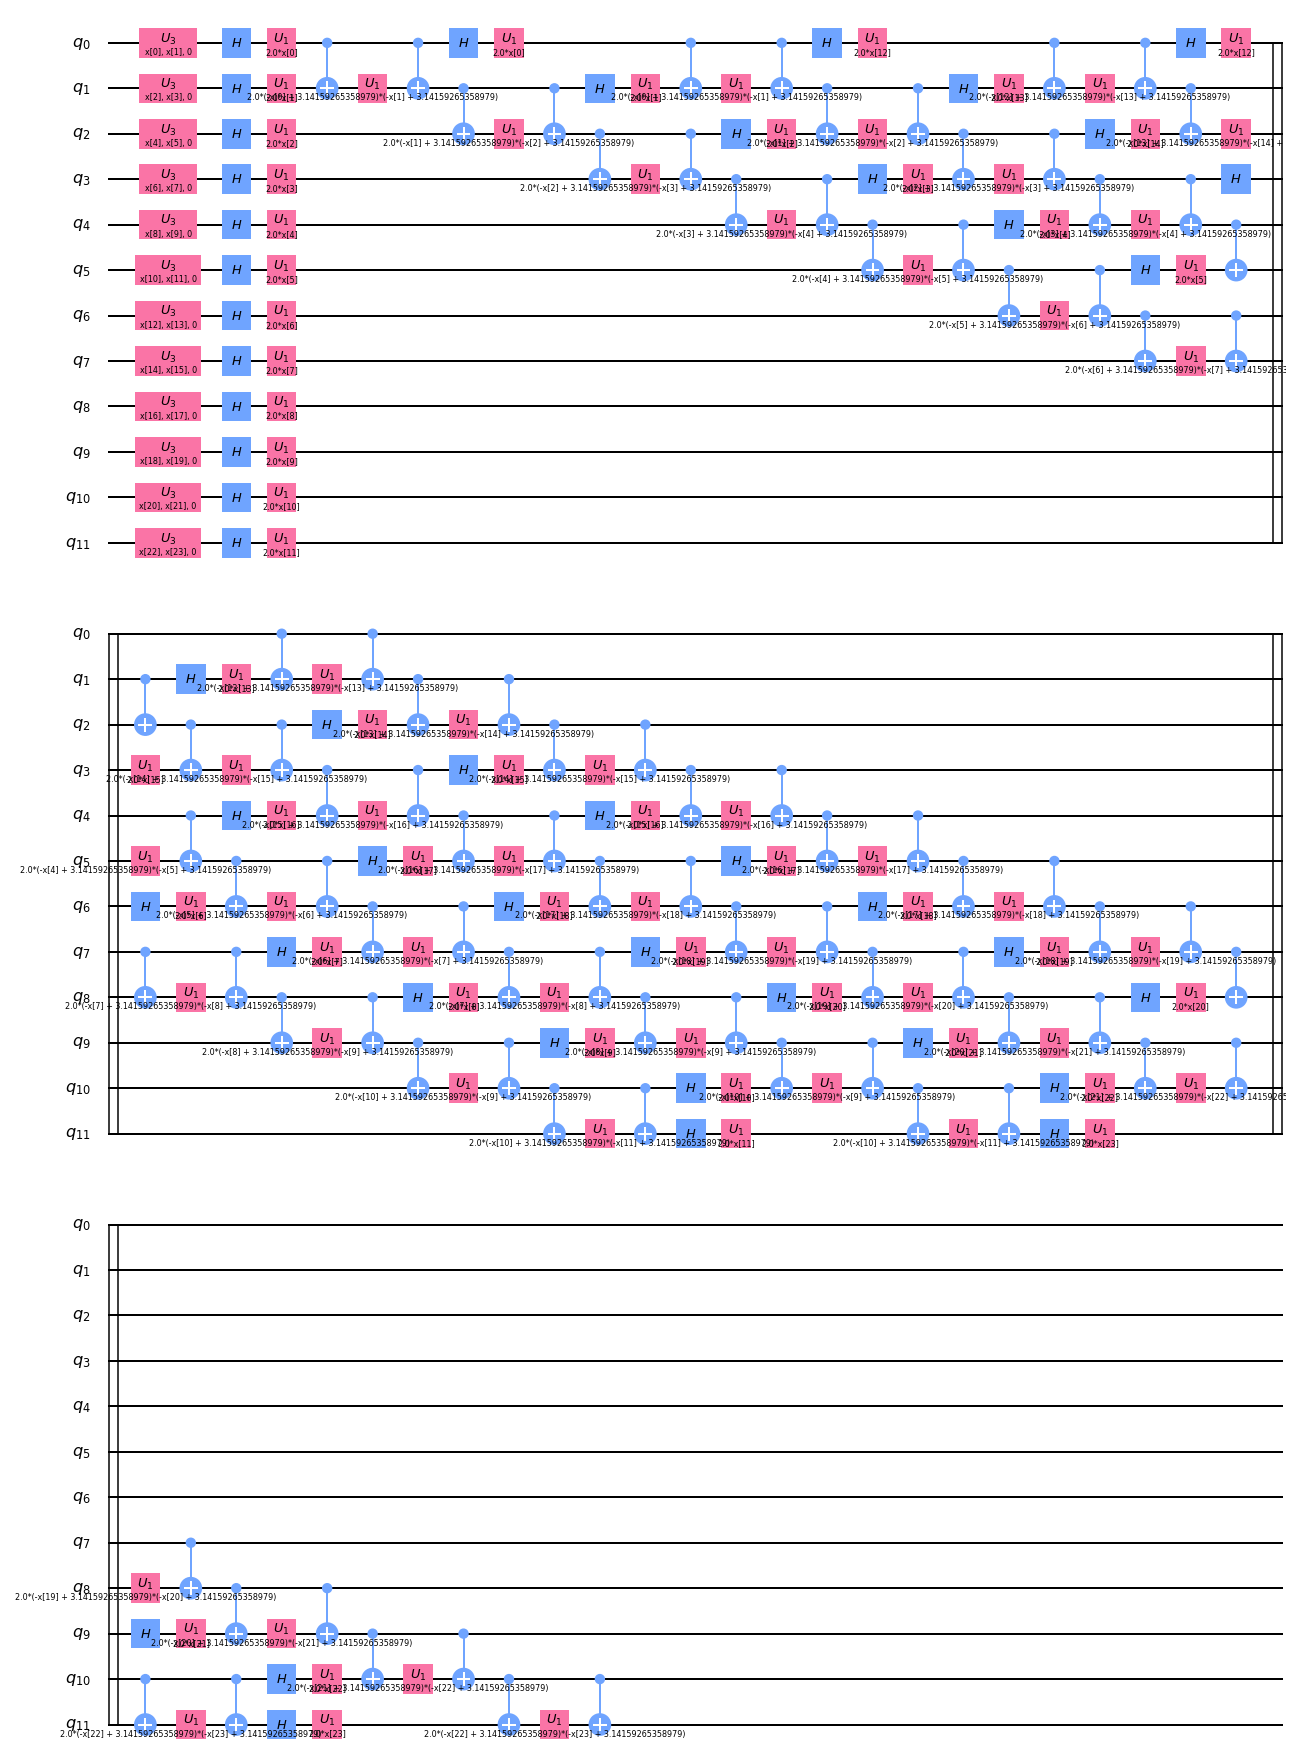

In [22]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter


# num_qubits = data.shape[1] // 2
feature_map = ZZFeatureMap(feature_dimension=num_qubit, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(num_qubit * 2)]

var_form = variational_forms.RYRZ(num_qubit)

qc = QuantumCircuit(num_qubit)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder
    

# Reassign the circuit variable
tmp1 = feature_map.assign_parameters(X[:num_qubit])
tmp2 = feature_map.assign_parameters(X[num_qubit:])

feature_map = qc + tmp1 + tmp2 
feature_map.draw('mpl')

In [23]:
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

seed = 10598

vqc_encode_only_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_log.append(loss)

qsvm_encode = VQC(SPSA(1000), feature_map, var_form, training_input, test_input, minibatch_size=200, callback=loss_history_callback)

# backend = BasicAer.get_backend('qasm_simulator')

backend_options = {"method": "statevector_gpu"}
backend = QasmSimulator(backend_options)

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

C:\Users\DELL GAMING\Miniconda3\envs\deeplr\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  # This is added back by InteractiveShellApp.init_path()
2020-07-23 22:43:51,274:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.2
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initi

2020-07-23 22:44:22,650:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:44:24,804:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.688654299860288
2020-07-23 22:44:27,466:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:44:29,894:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.699484162523704
2020-07-23 22:44:32,579:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:44:34,979:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6855249074479356
2020-07-23 22:44:37,598:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:44:39,832:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6987717087110147
2020-07-23 22:44:39,833:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step

2020-07-23 22:47:16,104:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6908057165942677
2020-07-23 22:47:18,841:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:47:21,094:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6932644052264176
2020-07-23 22:47:23,853:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:47:26,183:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6978061422141099
2020-07-23 22:47:28,885:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:47:31,112:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6907021105899088
2020-07-23 22:47:33,950:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:47:36,222:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-07-23 22:49:34,571:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6979389877848863
2020-07-23 22:49:34,573:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 8: 0.6918019
2020-07-23 22:49:34,574:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 8: 0.6979390
2020-07-23 22:49:37,362:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:49:39,804:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6925421212535388
2020-07-23 22:49:42,335:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:49:44,744:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6899990629640101
2020-07-23 22:49:44,745:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 9: 0.6925421
2020-07-23 22:49:44,746:qiskit.aqua.components.optimizers.s

2020-07-23 22:51:30,162:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6956396469393914
2020-07-23 22:51:33,242:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:51:35,507:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6887059568611535
2020-07-23 22:51:35,509:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 20: 0.6956396
2020-07-23 22:51:35,510:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 20: 0.6887060
2020-07-23 22:51:37,913:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:51:40,366:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6857685063519526
2020-07-23 22:51:43,186:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:51:45,750:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-23 22:53:16,776:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 31: 0.6965436
2020-07-23 22:53:19,428:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:53:21,441:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6970387243994328
2020-07-23 22:53:23,946:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:53:26,064:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7004086402763429
2020-07-23 22:53:26,065:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 32: 0.6970387
2020-07-23 22:53:26,066:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 32: 0.7004086
2020-07-23 22:53:28,565:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:53:30,647:qiskit.aqua.algorithms.classifi

2020-07-23 22:55:06,691:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6995593367728566
2020-07-23 22:55:06,692:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 43: 0.6820968
2020-07-23 22:55:06,692:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 43: 0.6995593
2020-07-23 22:55:09,155:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:55:11,117:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6930047775176411
2020-07-23 22:55:13,543:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-23 22:55:15,535:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6934598981525284
2020-07-23 22:55:15,536:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 44: 0.6930048
2020-07-23 22:55:15,537:qiskit.aqua.components.optimizer

KeyboardInterrupt: 

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


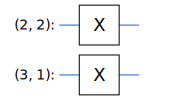

In [16]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [17]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [40]:
def convert_to_circuit(data):
    """Encode truncated classical image into quantum datapoint."""
    values = data
    qubits = cirq.GridQubit.rect(num_qubit,1)
    circuit = cirq.Circuit()
    for i in range(len(data) // 2):
        circuit.append(cirq.rx(data[2*i])(qubits[i]))
        circuit.append(cirq.ry(data[2*i+1])(qubits[i]))
#     for i, value in enumerate(values):
#         if value:
#             circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in data_train]
x_test_circ = [convert_to_circuit(x) for x in data_test]

In [41]:
data_train[1]

array([ 2.18627604, -2.35619449,  2.18627604, -0.78539816,  2.18627604,
       -0.78539816,  2.18627604, -2.35619449,  2.18627604,  2.35619449,
        2.18627604,  2.35619449,  2.18627604, -0.78539816,  2.18627604,
       -0.78539816,  2.18627604, -2.35619449,  2.18627604,  2.35619449,
        2.18627604,  2.35619449,  2.18627604, -2.35619449])

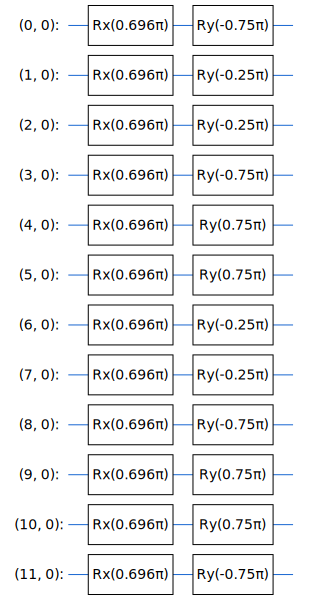

In [42]:
SVGCircuit(x_train_circ[1])

In [43]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [33]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
            print(cirq.unitary(gate(qubit, self.readout)**0.98))

Build an example circuit layer to see how it looks:

[[9.86635786e-04+0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.99013364e-01-0.03139526j]
 [0.00000000e+00+0.j         9.86635786e-04+0.03139526j
  9.99013364e-01-0.03139526j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         9.99013364e-01-0.03139526j
  9.86635786e-04+0.03139526j 0.00000000e+00+0.j        ]
 [9.99013364e-01-0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.86635786e-04+0.03139526j]]
[[9.86635786e-04+0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.99013364e-01-0.03139526j]
 [0.00000000e+00+0.j         9.86635786e-04+0.03139526j
  9.99013364e-01-0.03139526j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         9.99013364e-01-0.03139526j
  9.86635786e-04+0.03139526j 0.00000000e+00+0.j        ]
 [9.99013364e-01-0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.86635786e-04+0.03139526j]]
[[9.86635786e-04+0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.99013364e-01-0.03139526j]
 [0.00000000e+00+0.j 

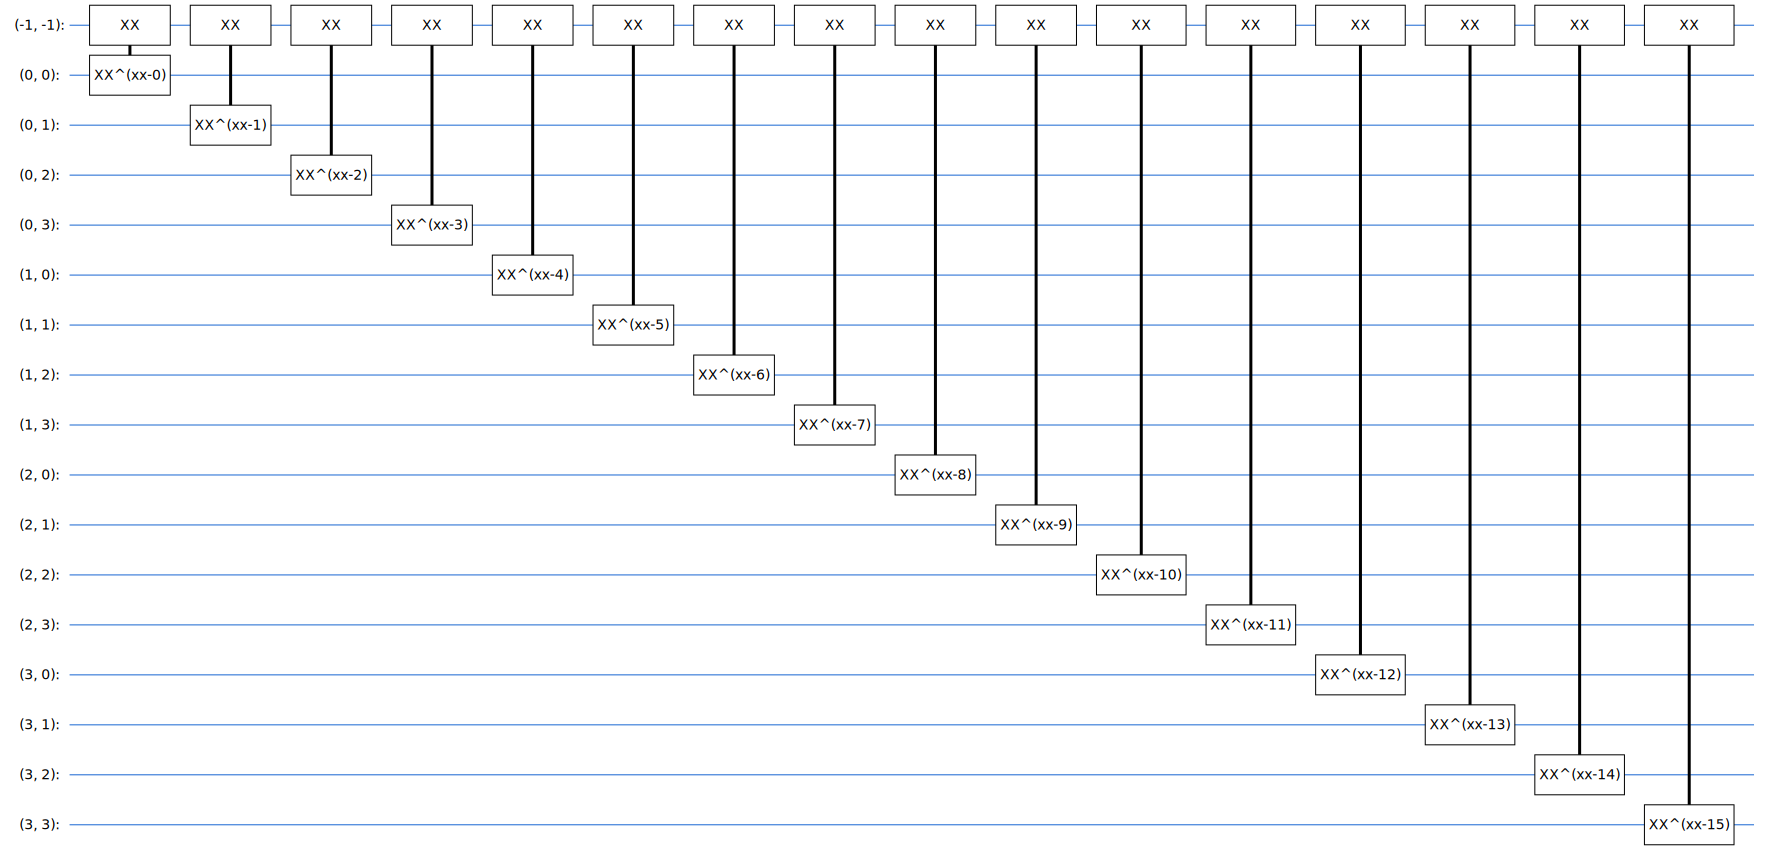

In [34]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,4),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [16]:
num_qubit = 10

In [17]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(num_qubit,1)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [18]:
model_circuit, model_readout = create_quantum_model()

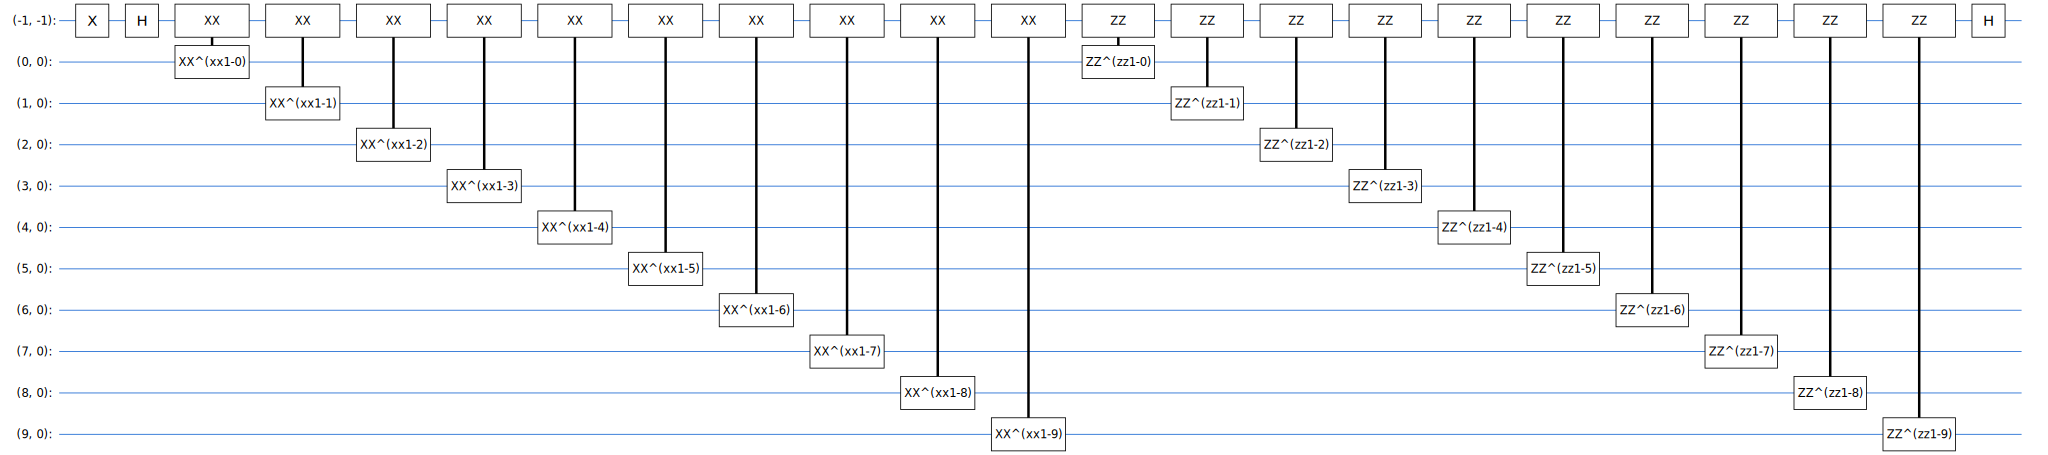

In [19]:
SVGCircuit(model_circuit)

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [49]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [50]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [51]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [52]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [53]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 24        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________
None


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [54]:
EPOCHS = 10
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)
# NUM_EXAMPLES = 1000

In [55]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [56]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 11520 samples, validate on 1968 samples
Epoch 1/10
11520/11520 [==============================] - 144s 12ms/sample - loss: 0.8036 - hinge_accuracy: 0.8194 - val_loss: 0.7232 - val_hinge_accuracy: 0.9027
Epoch 2/10
11520/11520 [==============================] - 143s 12ms/sample - loss: 0.7013 - hinge_accuracy: 0.8793 - val_loss: 0.6875 - val_hinge_accuracy: 0.8886
Epoch 3/10
11520/11520 [==============================] - 143s 12ms/sample - loss: 0.6837 - hinge_accuracy: 0.8770 - val_loss: 0.6779 - val_hinge_accuracy: 0.8886
Epoch 4/10
11520/11520 [==============================] - 142s 12ms/sample - loss: 0.6773 - hinge_accuracy: 0.8737 - val_loss: 0.6733 - val_hinge_accuracy: 0.8886
Epoch 5/10
11520/11520 [==============================] - 142s 12ms/sample - loss: 0.6749 - hinge_accuracy: 0.8748 - val_loss: 0.6747 - val_hinge_accuracy: 0.8886
Epoch 6/10
11520/11520 [==============================] - 143s 12ms/sample - loss: 0.6744 - hinge_accuracy: 0.8751 - val_loss: 0.6727 - 

Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

In [2]:
import glob
import pickle

hist = {
    
}

seeds = [111,222,333,444,555]
methods = ['qrac', 'conv_h', 'conv_v', 'conv_h_overlap', '16px', 'conv_all']

for method in methods:
    hist[method] = {}
    for seed in seeds:
        for file in glob.glob(f'results/{method}*_{seed}_*'):
            with open(file, 'rb') as f:
                hist[method][seed] = pickle.load(f)



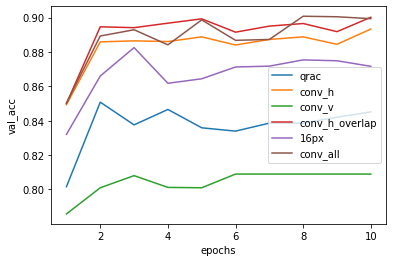

In [4]:
for method in methods:
    val_coll = []
    for seed in seeds:
        val_coll.append(hist[method][seed]['val_hinge_accuracy'])
    x_plot = np.arange(1,11)
    val_mean = np.mean(np.array(val_coll), axis=0)
    val_std = np.std(np.array(val_coll), axis=0)
    plt.plot(x_plot, val_mean, label=method)
    
plt.xlabel('epochs')
plt.ylabel('val_acc')
plt.legend()

In [35]:
import glob
import pickle

hist = {
    
}

seeds = [111,222,333,444]
methods = ['qrac', 'conv_h', 'conv_v', 'conv_h_overlap', '16px', 'conv_all']

for method in methods:
    hist[method] = {}
    for seed in seeds:
        for file in glob.glob(f'results/{method}*_2_{seed}_*'):
            with open(file, 'rb') as f:
                hist[method][seed] = pickle.load(f)



In [37]:
hist

{'qrac': {111: {'loss': [0.7874465710586972,
    0.6710860518945588,
    0.6545541253354814,
    0.6438030040926404,
    0.6405316360294819],
   'hinge_accuracy': [0.7890625, 0.8617188, 0.872309, 0.88359374, 0.88993055],
   'val_loss': [0.6871846371549901,
    0.6609049197134933,
    0.6476736737460624,
    0.6451778276179864,
    0.6441766561531439],
   'val_hinge_accuracy': [0.8518145,
    0.8503024,
    0.9032258,
    0.9042339,
    0.9042339]},
  222: {'loss': [0.8426649572120772,
    0.6931963385807143,
    0.6788526540001233,
    0.6738032549619675,
    0.6655170735385683],
   'hinge_accuracy': [0.7578125, 0.8460938, 0.8598958, 0.86154515, 0.8532118],
   'val_loss': [0.7242486161914298,
    0.685164543186746,
    0.6776497441578687,
    0.6708950187132611,
    0.6590277760978637],
   'val_hinge_accuracy': [0.8064516,
    0.8719758,
    0.8825605,
    0.8825605,
    0.85685486]},
  333: {'loss': [0.8160247387157546,
    0.6805662982993655,
    0.6555135246780184,
    0.65146026859

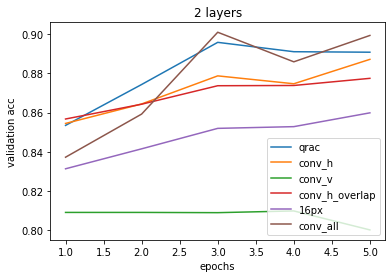

In [40]:
for method in methods:
    val_coll = []
    for seed in seeds:
        val_coll.append(hist[method][seed]['val_hinge_accuracy'])
    x_plot = np.arange(1,6)
    val_mean = np.mean(np.array(val_coll), axis=0)
    val_std = np.std(np.array(val_coll), axis=0)
    plt.plot(x_plot, val_mean, label=method)
    
plt.xlabel('epochs')
plt.ylabel('validation acc')
plt.title('2 layers')
plt.legend()

## 3. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [31]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [32]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

Train on 12049 samples, validate on 1968 samples
1968/1968 [==============================] - 0s 106us/sample - loss: 0.0024 - accuracy: 0.9995


The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [33]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Train on 11520 samples, validate on 1968 samples
Epoch 1/20
11520/11520 - 0s - loss: 0.6458 - accuracy: 0.5267 - val_loss: 0.6227 - val_accuracy: 0.5991
Epoch 2/20
11520/11520 - 0s - loss: 0.5767 - accuracy: 0.6639 - val_loss: 0.5467 - val_accuracy: 0.7165
Epoch 3/20
11520/11520 - 0s - loss: 0.4923 - accuracy: 0.7615 - val_loss: 0.4647 - val_accuracy: 0.7754
Epoch 4/20
11520/11520 - 0s - loss: 0.4170 - accuracy: 0.7968 - val_loss: 0.3992 - val_accuracy: 0.7912
Epoch 5/20
11520/11520 - 0s - loss: 0.3586 - accuracy: 0.8244 - val_loss: 0.3507 - val_accuracy: 0.8176
Epoch 6/20
11520/11520 - 0s - loss: 0.3166 - accuracy: 0.8576 - val_loss: 0.3160 - val_accuracy: 0.8288
Epoch 7/20
11520/11520 - 0s - loss: 0.2870 - accuracy: 0.8600 - val_loss: 0.2911 - val_accuracy: 0.8283
Epoch 8/20
11520/11520 - 0s - loss: 0.2661 - accuracy: 0.8603 - val_loss: 0.2733 - val_accuracy: 0.8277
Epoch 9/20
11520/11520 - 0s - loss: 0.2510 - accuracy: 0.8600 - val_loss: 0.2601 - val_accuracy: 0.8323
Epoch 10/20
115

## 4. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

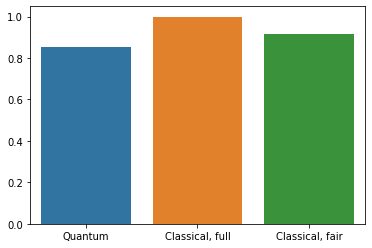

In [35]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])